## 1. Instalación de dependencias
Instalamos OpenCV, NumPy, Matplotlib y MoviePy.


In [ ]:
!pip install --quiet opencv-python-headless numpy matplotlib moviepy

## 2. Importar librerías y funciones auxiliares
Definimos umbrales y recorte de región de interés.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def abs_sobel_thresh(img, orient='x', thresh=(20, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, dx=1 if orient == 'x' else 0, dy=1 if orient == 'y' else 0, ksize=3)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255 * abs_sobel / np.max(abs_sobel)) if np.max(abs_sobel) != 0 else np.zeros_like(abs_sobel)
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary_output

def color_threshold(img, sthresh=(170, 255), vthresh=(50, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:, :, 2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1

    return np.logical_and(s_binary, v_binary).astype(np.uint8)

def color_threshold(img, sthresh=(100, 255), vthresh=(50, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    return cv2.bitwise_and(s_binary, v_binary)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [vertices], 1)
    return cv2.bitwise_and(img, mask)

## 3. Definir transformaciones de perspectiva
Ajusta los puntos `src`/`dst` según tu metraje.

In [ ]:
# Coordenadas de ejemplo en píxeles
src = np.float32([
    [580, 460],  # arriba izquierda
    [700, 460],  # arriba derecha
    [1100, 720], # abajo derecha
    [260, 720]   # abajo izquierda
])
dst = np.float32([
    [260, 0],
    [1040, 0],
    [1040, 720],
    [260, 720]
])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)


## 4. Pipeline de segmentación de carriles
Combina umbrales, perspectiva y sliding windows.

In [ ]:
def segment_lanes(img):
    # 4.1 Mezcla de umbrales
    gradx = abs_sobel_thresh(img, orient='x', thresh=(5, 255))
    color_bin = color_threshold(img, sthresh=(50, 255), vthresh=(30, 255))

    combined = np.zeros_like(gradx)
    combined[(gradx == 1) | (color_bin == 1)] = 1

    # 4.2 Región de interés
    h, w = combined.shape
    verts = np.array([[  # Trapezoide ajustado
        (w * 0.1, h),
        (w * 0.4, h * 0.85),
        (w * 0.6, h * 0.85),
        (w * 0.9, h)
    ]], dtype=np.int32)

    roi = region_of_interest(combined, verts)

    # 4.3 Transformación de perspectiva
    src = np.float32([
        [w * 0.1, h * 0.85],
        [w * 0.9, h * 0.85],
        [w * 0.95, h],
        [w * 0.05, h]
    ])

    dst = np.float32([
        [w * 0.2, 0],
        [w * 0.8, 0],
        [w * 0.8, h],
        [w * 0.2, h]
    ])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)  # Para revertir la perspectiva al final
    warped = cv2.warpPerspective(roi, M, (w, h), flags=cv2.INTER_LINEAR)

    # 4.4 Sliding windows
    histogram = np.sum(warped[h//2:, :], axis=0)
    midpoint = histogram.shape[0] // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_h = h // nwindows
    nonzero = warped.nonzero()
    nonzeroy, nonzerox = np.array(nonzero[0]), np.array(nonzero[1])
    leftx_cur, rightx_cur = leftx_base, rightx_base
    margin, minpix = 100, 50
    left_inds, right_inds = [], []

    for window in range(nwindows):
        y_low = h - (window + 1) * window_h
        y_high = h - window * window_h
        xl_low, xl_high = leftx_cur - margin, leftx_cur + margin
        xr_low, xr_high = rightx_cur - margin, rightx_cur + margin

        good_left = ((nonzeroy >= y_low) & (nonzeroy < y_high) &
                     (nonzerox >= xl_low) & (nonzerox < xl_high)).nonzero()[0]
        good_right = ((nonzeroy >= y_low) & (nonzeroy < y_high) &
                      (nonzerox >= xr_low) & (nonzerox < xr_high)).nonzero()[0]

        left_inds.append(good_left)
        right_inds.append(good_right)

        if len(good_left) > minpix:
            leftx_cur = int(np.mean(nonzerox[good_left]))
        if len(good_right) > minpix:
            rightx_cur = int(np.mean(nonzerox[good_right]))

    left_inds = np.concatenate(left_inds) if any(len(x) > 0 for x in left_inds) else np.array([])
    right_inds = np.concatenate(right_inds) if any(len(x) > 0 for x in right_inds) else np.array([])

    print(f"left_inds: {left_inds.size}, right_inds: {right_inds.size}")
    if left_inds.size < 10 or right_inds.size < 10:
        print("No se detectaron suficientes puntos.")
        return img.copy()

    leftx, lefty = nonzerox[left_inds], nonzeroy[left_inds]
    rightx, righty = nonzerox[right_inds], nonzeroy[right_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, h - 1, h)
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Dibujar área entre líneas
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h))
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    return result

## 5. Probar con un fotograma de ejemplo
Carga una imagen de prueba y aplica `segment_lanes()`.

left_inds: 297436, right_inds: 248317


(np.float64(-0.5), np.float64(4079.5), np.float64(3059.5), np.float64(-0.5))

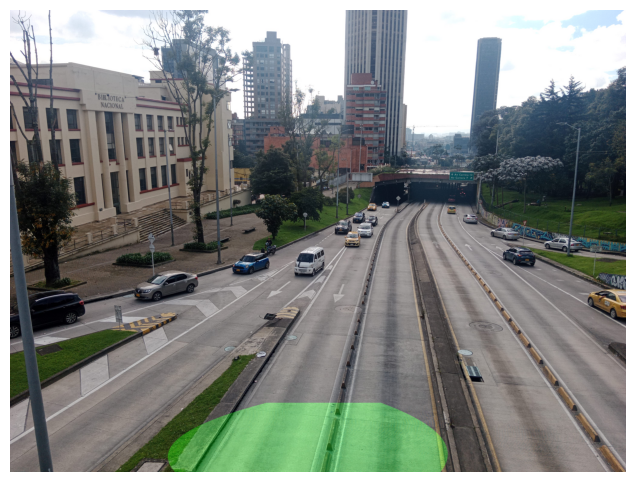

In [ ]:
# Ajusta la ruta a tu imagen
frame = cv2.imread('../data/fotos VPC/IMG_20250522_154356_Burst05.jpg')
out   = segment_lanes(frame)
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.axis('off')

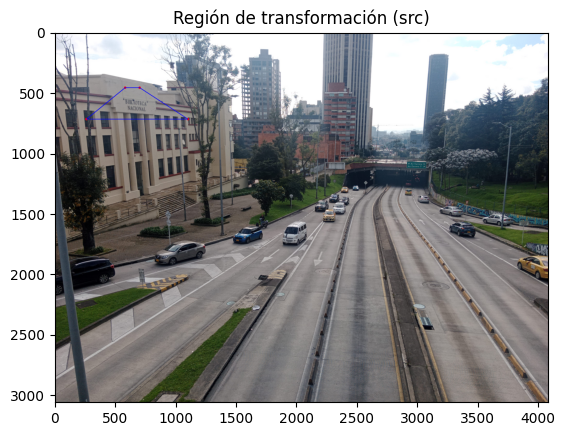

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Dibuja los puntos de origen en la imagen
img_copy = cv2.imread('/content/sample_frame.jpg')
for point in src:
    cv2.circle(img_copy, tuple(np.int32(point)), 10, (0,0,255), -1)

pts = src.reshape((-1, 1, 2)).astype(np.int32)
cv2.polylines(img_copy, [pts], isClosed=True, color=(255, 0, 0), thickness=3)

plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.title('Región de transformación (src)')
plt.show()


## 6. Procesar un video completo
Usamos MoviePy para aplicar la función a cada frame.

In [ ]:
from moviepy.editor import VideoFileClip

def process_frame(f):
    return segment_lanes(f)

input_path  = '../data/videos VPC/20250522_061210.mp4'
output_path = 'output_lanes.mp4'

clip     = VideoFileClip(input_path)
out_clip = clip.fl_image(process_frame)
out_clip.write_videofile(output_path, audio=False)

print('✅ Video procesado guardado en:', output_path)

left_inds: 33748, right_inds: 108557
Moviepy - Building video /content/output_lanes.mp4.
Moviepy - Writing video /content/output_lanes.mp4



t:   0%|          | 0/1960 [00:00<?, ?it/s, now=None]

left_inds: 33748, right_inds: 108557


t:   0%|          | 2/1960 [00:00<02:53, 11.27it/s, now=None]

left_inds: 30422, right_inds: 108178


t:   0%|          | 4/1960 [00:00<05:10,  6.30it/s, now=None]

left_inds: 31703, right_inds: 110595


t:   0%|          | 5/1960 [00:00<05:40,  5.74it/s, now=None]

left_inds: 32947, right_inds: 110619
left_inds: 34744, right_inds: 110186


t:   0%|          | 7/1960 [00:01<06:05,  5.34it/s, now=None]

left_inds: 36305, right_inds: 109757
left_inds: 36335, right_inds: 109512


t:   0%|          | 9/1960 [00:01<06:18,  5.15it/s, now=None]

left_inds: 33276, right_inds: 108802


t:   1%|          | 10/1960 [00:01<06:37,  4.91it/s, now=None]

left_inds: 36878, right_inds: 109690
left_inds: 36752, right_inds: 110392


t:   1%|          | 12/1960 [00:02<06:26,  5.03it/s, now=None]

left_inds: 35009, right_inds: 109893
left_inds: 31049, right_inds: 107751


t:   1%|          | 14/1960 [00:02<07:14,  4.48it/s, now=None]

left_inds: 30851, right_inds: 107130


t:   1%|          | 15/1960 [00:03<08:26,  3.84it/s, now=None]

left_inds: 31487, right_inds: 108037


t:   1%|          | 16/1960 [00:03<09:08,  3.54it/s, now=None]

left_inds: 32003, right_inds: 107845


t:   1%|          | 17/1960 [00:03<09:37,  3.37it/s, now=None]

left_inds: 33615, right_inds: 108535


t:   1%|          | 18/1960 [00:04<09:57,  3.25it/s, now=None]

left_inds: 34683, right_inds: 108253


t:   1%|          | 19/1960 [00:04<10:08,  3.19it/s, now=None]

left_inds: 30961, right_inds: 106382


t:   1%|          | 20/1960 [00:04<10:12,  3.17it/s, now=None]

left_inds: 29662, right_inds: 106011


t:   1%|          | 21/1960 [00:05<10:15,  3.15it/s, now=None]

left_inds: 33348, right_inds: 107358


t:   1%|          | 22/1960 [00:05<10:22,  3.11it/s, now=None]

left_inds: 32551, right_inds: 102224


t:   1%|          | 23/1960 [00:05<09:59,  3.23it/s, now=None]

left_inds: 31782, right_inds: 106293


t:   1%|          | 24/1960 [00:05<10:07,  3.19it/s, now=None]

left_inds: 31257, right_inds: 100512


t:   1%|▏         | 25/1960 [00:06<09:59,  3.23it/s, now=None]

left_inds: 28870, right_inds: 103942


t:   1%|▏         | 26/1960 [00:06<09:48,  3.29it/s, now=None]

left_inds: 30643, right_inds: 104336


t:   1%|▏         | 27/1960 [00:06<08:49,  3.65it/s, now=None]

left_inds: 33169, right_inds: 102329
left_inds: 29599, right_inds: 102369


t:   1%|▏         | 29/1960 [00:07<07:37,  4.22it/s, now=None]

left_inds: 29454, right_inds: 102932
left_inds: 29222, right_inds: 102243


t:   2%|▏         | 31/1960 [00:07<06:59,  4.60it/s, now=None]

left_inds: 29789, right_inds: 100607


t:   2%|▏         | 32/1960 [00:07<06:53,  4.66it/s, now=None]

left_inds: 27052, right_inds: 100521
left_inds: 24006, right_inds: 99436


t:   2%|▏         | 34/1960 [00:08<06:41,  4.79it/s, now=None]

left_inds: 23736, right_inds: 99342


t:   2%|▏         | 35/1960 [00:08<06:32,  4.90it/s, now=None]

left_inds: 25461, right_inds: 100899
left_inds: 23634, right_inds: 99645


t:   2%|▏         | 37/1960 [00:08<06:22,  5.03it/s, now=None]

left_inds: 26407, right_inds: 101477
left_inds: 27740, right_inds: 102137


t:   2%|▏         | 39/1960 [00:09<06:18,  5.08it/s, now=None]

left_inds: 26285, right_inds: 101383


t:   2%|▏         | 40/1960 [00:09<06:22,  5.02it/s, now=None]

left_inds: 24963, right_inds: 99329
left_inds: 26068, right_inds: 98542


t:   2%|▏         | 42/1960 [00:09<06:16,  5.09it/s, now=None]

left_inds: 28345, right_inds: 100249
left_inds: 29190, right_inds: 100346


t:   2%|▏         | 44/1960 [00:10<06:55,  4.61it/s, now=None]

left_inds: 29263, right_inds: 99108


t:   2%|▏         | 45/1960 [00:10<07:50,  4.07it/s, now=None]

left_inds: 24684, right_inds: 99075


t:   2%|▏         | 46/1960 [00:10<08:17,  3.85it/s, now=None]

left_inds: 21544, right_inds: 97282


t:   2%|▏         | 47/1960 [00:11<08:35,  3.71it/s, now=None]

left_inds: 21029, right_inds: 94149


t:   2%|▏         | 48/1960 [00:11<08:50,  3.61it/s, now=None]

left_inds: 20642, right_inds: 98611
left_inds: 17784, right_inds: 95622


t:   3%|▎         | 50/1960 [00:12<09:57,  3.20it/s, now=None]

left_inds: 18080, right_inds: 96084


t:   3%|▎         | 51/1960 [00:12<09:23,  3.39it/s, now=None]

left_inds: 15671, right_inds: 94320


t:   3%|▎         | 52/1960 [00:12<09:02,  3.52it/s, now=None]

left_inds: 14283, right_inds: 93701


t:   3%|▎         | 53/1960 [00:12<09:26,  3.36it/s, now=None]

left_inds: 14609, right_inds: 94160


t:   3%|▎         | 54/1960 [00:13<09:51,  3.22it/s, now=None]

left_inds: 15426, right_inds: 94035


t:   3%|▎         | 55/1960 [00:13<09:26,  3.36it/s, now=None]

left_inds: 16923, right_inds: 95075


t:   3%|▎         | 56/1960 [00:13<09:02,  3.51it/s, now=None]

left_inds: 18240, right_inds: 94216


t:   3%|▎         | 57/1960 [00:14<09:51,  3.22it/s, now=None]

left_inds: 17116, right_inds: 94052


t:   3%|▎         | 58/1960 [00:14<09:48,  3.23it/s, now=None]

left_inds: 18158, right_inds: 95100


t:   3%|▎         | 59/1960 [00:14<09:20,  3.39it/s, now=None]

left_inds: 16729, right_inds: 93986


t:   3%|▎         | 60/1960 [00:15<08:58,  3.53it/s, now=None]

left_inds: 17540, right_inds: 93617


t:   3%|▎         | 61/1960 [00:15<09:46,  3.24it/s, now=None]

left_inds: 17883, right_inds: 95499


t:   3%|▎         | 62/1960 [00:15<09:41,  3.26it/s, now=None]

left_inds: 15150, right_inds: 92764


t:   3%|▎         | 63/1960 [00:15<09:08,  3.46it/s, now=None]

left_inds: 15405, right_inds: 92316


t:   3%|▎         | 64/1960 [00:16<08:47,  3.60it/s, now=None]

left_inds: 14828, right_inds: 91856


t:   3%|▎         | 65/1960 [00:16<09:44,  3.24it/s, now=None]

left_inds: 16641, right_inds: 92801


t:   3%|▎         | 66/1960 [00:17<11:10,  2.82it/s, now=None]

left_inds: 17292, right_inds: 93298


t:   3%|▎         | 67/1960 [00:17<11:32,  2.73it/s, now=None]

left_inds: 16742, right_inds: 92460


t:   3%|▎         | 68/1960 [00:17<12:51,  2.45it/s, now=None]

left_inds: 19453, right_inds: 92566


t:   4%|▎         | 69/1960 [00:18<14:56,  2.11it/s, now=None]

left_inds: 28651, right_inds: 94475


t:   4%|▎         | 70/1960 [00:19<15:17,  2.06it/s, now=None]

left_inds: 31463, right_inds: 95373


t:   4%|▎         | 71/1960 [00:19<14:35,  2.16it/s, now=None]

left_inds: 19056, right_inds: 96269


t:   4%|▎         | 72/1960 [00:19<14:34,  2.16it/s, now=None]

left_inds: 86323, right_inds: 96919


t:   4%|▎         | 73/1960 [00:20<14:55,  2.11it/s, now=None]

left_inds: 129669, right_inds: 108923


t:   4%|▍         | 74/1960 [00:20<14:56,  2.10it/s, now=None]

left_inds: 156017, right_inds: 121121


t:   4%|▍         | 75/1960 [00:21<14:31,  2.16it/s, now=None]

left_inds: 150290, right_inds: 126677


t:   4%|▍         | 76/1960 [00:21<12:54,  2.43it/s, now=None]

left_inds: 136713, right_inds: 124829


t:   4%|▍         | 77/1960 [00:22<12:40,  2.48it/s, now=None]

left_inds: 108559, right_inds: 127363


t:   4%|▍         | 78/1960 [00:22<11:43,  2.67it/s, now=None]

left_inds: 71777, right_inds: 118853


t:   4%|▍         | 79/1960 [00:22<10:51,  2.89it/s, now=None]

left_inds: 89841, right_inds: 106381


t:   4%|▍         | 80/1960 [00:22<10:00,  3.13it/s, now=None]

left_inds: 95924, right_inds: 104337


t:   4%|▍         | 81/1960 [00:23<10:45,  2.91it/s, now=None]

left_inds: 94629, right_inds: 106998


t:   4%|▍         | 82/1960 [00:23<10:18,  3.04it/s, now=None]

left_inds: 84110, right_inds: 105697


t:   4%|▍         | 83/1960 [00:23<09:43,  3.22it/s, now=None]

left_inds: 66380, right_inds: 101495


t:   4%|▍         | 84/1960 [00:24<09:20,  3.35it/s, now=None]

left_inds: 47461, right_inds: 102299


t:   4%|▍         | 85/1960 [00:24<10:07,  3.09it/s, now=None]

left_inds: 35979, right_inds: 102379


t:   4%|▍         | 86/1960 [00:24<09:47,  3.19it/s, now=None]

left_inds: 41121, right_inds: 104015


t:   4%|▍         | 87/1960 [00:25<09:22,  3.33it/s, now=None]

left_inds: 40249, right_inds: 103901


t:   4%|▍         | 88/1960 [00:25<09:09,  3.40it/s, now=None]

left_inds: 40310, right_inds: 103914


t:   5%|▍         | 89/1960 [00:25<12:07,  2.57it/s, now=None]

left_inds: 31798, right_inds: 107259


t:   5%|▍         | 90/1960 [00:26<13:56,  2.24it/s, now=None]

left_inds: 33295, right_inds: 107335


t:   5%|▍         | 91/1960 [00:26<13:45,  2.26it/s, now=None]

left_inds: 26150, right_inds: 105924


t:   5%|▍         | 92/1960 [00:27<13:57,  2.23it/s, now=None]

left_inds: 25207, right_inds: 111927


t:   5%|▍         | 93/1960 [00:27<13:43,  2.27it/s, now=None]

left_inds: 36893, right_inds: 113032


t:   5%|▍         | 94/1960 [00:28<12:21,  2.52it/s, now=None]

left_inds: 48003, right_inds: 118091


t:   5%|▍         | 95/1960 [00:28<11:05,  2.80it/s, now=None]

left_inds: 45189, right_inds: 117452


t:   5%|▍         | 96/1960 [00:28<10:31,  2.95it/s, now=None]

left_inds: 47753, right_inds: 116406


t:   5%|▍         | 97/1960 [00:29<10:54,  2.84it/s, now=None]

left_inds: 47225, right_inds: 117399


t:   5%|▌         | 98/1960 [00:29<10:19,  3.01it/s, now=None]

left_inds: 50846, right_inds: 121619


t:   5%|▌         | 99/1960 [00:29<09:56,  3.12it/s, now=None]

left_inds: 54775, right_inds: 123324


t:   5%|▌         | 100/1960 [00:29<09:30,  3.26it/s, now=None]

left_inds: 58528, right_inds: 121655


t:   5%|▌         | 101/1960 [00:30<10:13,  3.03it/s, now=None]

left_inds: 54222, right_inds: 121154


t:   5%|▌         | 102/1960 [00:30<09:56,  3.11it/s, now=None]

left_inds: 43358, right_inds: 118017


t:   5%|▌         | 103/1960 [00:30<09:30,  3.25it/s, now=None]

left_inds: 51013, right_inds: 124147


t:   5%|▌         | 104/1960 [00:31<09:04,  3.41it/s, now=None]

left_inds: 48627, right_inds: 123073


t:   5%|▌         | 105/1960 [00:31<11:07,  2.78it/s, now=None]

left_inds: 46871, right_inds: 122652


t:   5%|▌         | 106/1960 [00:32<13:13,  2.34it/s, now=None]

left_inds: 49461, right_inds: 123407


t:   5%|▌         | 107/1960 [00:32<14:06,  2.19it/s, now=None]

left_inds: 51868, right_inds: 125650


t:   6%|▌         | 108/1960 [00:33<14:10,  2.18it/s, now=None]

left_inds: 51330, right_inds: 127576
left_inds: 54613, right_inds: 128856


t:   6%|▌         | 110/1960 [00:34<16:17,  1.89it/s, now=None]

left_inds: 57075, right_inds: 125822


t:   6%|▌         | 111/1960 [00:34<15:17,  2.01it/s, now=None]

left_inds: 51946, right_inds: 126336


t:   6%|▌         | 112/1960 [00:35<14:37,  2.11it/s, now=None]

left_inds: 49797, right_inds: 126907


t:   6%|▌         | 113/1960 [00:35<15:14,  2.02it/s, now=None]

left_inds: 52016, right_inds: 127796


t:   6%|▌         | 114/1960 [00:36<13:39,  2.25it/s, now=None]

left_inds: 56687, right_inds: 129619


t:   6%|▌         | 115/1960 [00:36<12:06,  2.54it/s, now=None]

left_inds: 56196, right_inds: 131669


t:   6%|▌         | 116/1960 [00:36<10:54,  2.82it/s, now=None]

left_inds: 47412, right_inds: 129269


t:   6%|▌         | 117/1960 [00:37<11:11,  2.74it/s, now=None]

left_inds: 50822, right_inds: 132270


t:   6%|▌         | 118/1960 [00:37<10:38,  2.89it/s, now=None]

left_inds: 49088, right_inds: 130618


t:   6%|▌         | 119/1960 [00:37<09:58,  3.08it/s, now=None]

left_inds: 53342, right_inds: 132528


t:   6%|▌         | 120/1960 [00:37<09:41,  3.17it/s, now=None]

left_inds: 51390, right_inds: 130818


t:   6%|▌         | 121/1960 [00:38<10:20,  2.97it/s, now=None]

left_inds: 54692, right_inds: 133361


t:   6%|▌         | 122/1960 [00:38<09:54,  3.09it/s, now=None]

left_inds: 45746, right_inds: 128037


t:   6%|▋         | 123/1960 [00:38<09:24,  3.25it/s, now=None]

left_inds: 45065, right_inds: 129339


t:   6%|▋         | 124/1960 [00:39<09:11,  3.33it/s, now=None]

left_inds: 47184, right_inds: 129429


t:   6%|▋         | 125/1960 [00:39<09:35,  3.19it/s, now=None]

left_inds: 50018, right_inds: 131793


t:   6%|▋         | 126/1960 [00:39<09:35,  3.18it/s, now=None]

left_inds: 52634, right_inds: 132468


t:   6%|▋         | 127/1960 [00:40<09:09,  3.34it/s, now=None]

left_inds: 49996, right_inds: 131870


t:   7%|▋         | 128/1960 [00:40<09:06,  3.35it/s, now=None]

left_inds: 47235, right_inds: 130114


t:   7%|▋         | 129/1960 [00:40<09:25,  3.24it/s, now=None]

left_inds: 49584, right_inds: 132411


t:   7%|▋         | 130/1960 [00:41<09:32,  3.20it/s, now=None]

left_inds: 50614, right_inds: 133008


t:   7%|▋         | 131/1960 [00:41<09:17,  3.28it/s, now=None]

left_inds: 53965, right_inds: 134569


t:   7%|▋         | 132/1960 [00:41<08:54,  3.42it/s, now=None]

left_inds: 48829, right_inds: 132319


t:   7%|▋         | 133/1960 [00:41<09:25,  3.23it/s, now=None]

left_inds: 51664, right_inds: 133200


t:   7%|▋         | 134/1960 [00:42<09:25,  3.23it/s, now=None]

left_inds: 53911, right_inds: 132933


t:   7%|▋         | 135/1960 [00:42<09:11,  3.31it/s, now=None]

left_inds: 51030, right_inds: 132867


t:   7%|▋         | 136/1960 [00:42<08:49,  3.44it/s, now=None]

left_inds: 49401, right_inds: 131907


t:   7%|▋         | 137/1960 [00:43<09:39,  3.14it/s, now=None]

left_inds: 48118, right_inds: 131868


t:   7%|▋         | 138/1960 [00:43<09:55,  3.06it/s, now=None]

left_inds: 57552, right_inds: 135181


t:   7%|▋         | 139/1960 [00:43<09:27,  3.21it/s, now=None]

left_inds: 55063, right_inds: 131838


t:   7%|▋         | 140/1960 [00:44<09:02,  3.35it/s, now=None]

left_inds: 52257, right_inds: 131456


t:   7%|▋         | 141/1960 [00:44<09:27,  3.20it/s, now=None]

left_inds: 56233, right_inds: 132954


t:   7%|▋         | 142/1960 [00:44<09:40,  3.13it/s, now=None]

left_inds: 51201, right_inds: 130730


t:   7%|▋         | 143/1960 [00:45<09:12,  3.29it/s, now=None]

left_inds: 54412, right_inds: 131026


t:   7%|▋         | 144/1960 [00:45<08:56,  3.38it/s, now=None]

left_inds: 60615, right_inds: 132137


t:   7%|▋         | 145/1960 [00:45<09:52,  3.06it/s, now=None]

left_inds: 58190, right_inds: 133601


t:   7%|▋         | 146/1960 [00:46<10:33,  2.86it/s, now=None]

left_inds: 55841, right_inds: 132349


t:   8%|▊         | 147/1960 [00:46<11:17,  2.68it/s, now=None]

left_inds: 60859, right_inds: 134301


t:   8%|▊         | 148/1960 [00:46<11:38,  2.60it/s, now=None]

left_inds: 62830, right_inds: 133231
left_inds: 65782, right_inds: 135471


t:   8%|▊         | 150/1960 [00:48<14:31,  2.08it/s, now=None]

left_inds: 62103, right_inds: 134374


t:   8%|▊         | 151/1960 [00:48<14:35,  2.07it/s, now=None]

left_inds: 63128, right_inds: 134346


t:   8%|▊         | 152/1960 [00:49<14:32,  2.07it/s, now=None]

left_inds: 50405, right_inds: 130248


t:   8%|▊         | 153/1960 [00:49<15:15,  1.97it/s, now=None]

left_inds: 47131, right_inds: 128548


t:   8%|▊         | 154/1960 [00:50<14:38,  2.06it/s, now=None]

left_inds: 53225, right_inds: 130886


t:   8%|▊         | 155/1960 [00:50<13:31,  2.22it/s, now=None]

left_inds: 48831, right_inds: 129007


t:   8%|▊         | 156/1960 [00:50<12:02,  2.50it/s, now=None]

left_inds: 55639, right_inds: 131430


t:   8%|▊         | 157/1960 [00:51<11:44,  2.56it/s, now=None]

left_inds: 54814, right_inds: 132235


t:   8%|▊         | 158/1960 [00:51<10:49,  2.78it/s, now=None]

left_inds: 57580, right_inds: 131601


t:   8%|▊         | 159/1960 [00:51<09:57,  3.02it/s, now=None]

left_inds: 52721, right_inds: 119671


t:   8%|▊         | 160/1960 [00:51<09:29,  3.16it/s, now=None]

left_inds: 63230, right_inds: 132839


t:   8%|▊         | 161/1960 [00:52<09:55,  3.02it/s, now=None]

left_inds: 62483, right_inds: 134338


t:   8%|▊         | 162/1960 [00:52<09:26,  3.18it/s, now=None]

left_inds: 59913, right_inds: 132025


t:   8%|▊         | 163/1960 [00:52<09:05,  3.29it/s, now=None]

left_inds: 59474, right_inds: 131887


t:   8%|▊         | 164/1960 [00:53<08:56,  3.35it/s, now=None]

left_inds: 57362, right_inds: 131776


t:   8%|▊         | 165/1960 [00:53<09:45,  3.07it/s, now=None]

left_inds: 61076, right_inds: 132899


t:   8%|▊         | 166/1960 [00:53<09:28,  3.15it/s, now=None]

left_inds: 57067, right_inds: 131376


t:   9%|▊         | 167/1960 [00:54<09:17,  3.21it/s, now=None]

left_inds: 56096, right_inds: 130982


t:   9%|▊         | 168/1960 [00:54<08:52,  3.37it/s, now=None]

left_inds: 52451, right_inds: 126965


t:   9%|▊         | 169/1960 [00:54<09:26,  3.16it/s, now=None]

left_inds: 61829, right_inds: 132211


t:   9%|▊         | 170/1960 [00:55<09:09,  3.26it/s, now=None]

left_inds: 60181, right_inds: 131767


t:   9%|▊         | 171/1960 [00:55<09:04,  3.29it/s, now=None]

left_inds: 58408, right_inds: 130942


t:   9%|▉         | 172/1960 [00:55<08:47,  3.39it/s, now=None]

left_inds: 54394, right_inds: 128477


t:   9%|▉         | 173/1960 [00:56<09:24,  3.16it/s, now=None]

left_inds: 55290, right_inds: 130899


t:   9%|▉         | 174/1960 [00:56<09:14,  3.22it/s, now=None]

left_inds: 55597, right_inds: 129688


t:   9%|▉         | 175/1960 [00:56<09:04,  3.28it/s, now=None]

left_inds: 50321, right_inds: 129596


t:   9%|▉         | 176/1960 [00:56<08:44,  3.40it/s, now=None]

left_inds: 65753, right_inds: 131886


t:   9%|▉         | 177/1960 [00:57<09:20,  3.18it/s, now=None]

left_inds: 53143, right_inds: 131157


t:   9%|▉         | 178/1960 [00:57<09:38,  3.08it/s, now=None]

left_inds: 63431, right_inds: 129864


t:   9%|▉         | 179/1960 [00:57<09:09,  3.24it/s, now=None]

left_inds: 52438, right_inds: 130053


t:   9%|▉         | 180/1960 [00:58<08:47,  3.37it/s, now=None]

left_inds: 60702, right_inds: 130919


t:   9%|▉         | 181/1960 [00:58<09:33,  3.10it/s, now=None]

left_inds: 53784, right_inds: 128523


t:   9%|▉         | 182/1960 [00:58<09:11,  3.22it/s, now=None]

left_inds: 44955, right_inds: 130026


t:   9%|▉         | 183/1960 [00:59<08:45,  3.38it/s, now=None]

left_inds: 37577, right_inds: 128317


t:   9%|▉         | 184/1960 [00:59<08:29,  3.48it/s, now=None]

left_inds: 46204, right_inds: 130872


t:   9%|▉         | 185/1960 [00:59<09:17,  3.18it/s, now=None]

left_inds: 44320, right_inds: 130257


t:   9%|▉         | 186/1960 [00:59<09:05,  3.25it/s, now=None]

left_inds: 62773, right_inds: 132335


t:  10%|▉         | 187/1960 [01:00<08:47,  3.36it/s, now=None]

left_inds: 57824, right_inds: 130188


t:  10%|▉         | 188/1960 [01:00<09:30,  3.11it/s, now=None]

left_inds: 56918, right_inds: 130385


t:  10%|▉         | 189/1960 [01:01<11:24,  2.59it/s, now=None]

left_inds: 44581, right_inds: 130571


t:  10%|▉         | 190/1960 [01:01<12:40,  2.33it/s, now=None]

left_inds: 56484, right_inds: 129911


t:  10%|▉         | 191/1960 [01:02<12:47,  2.30it/s, now=None]

left_inds: 42467, right_inds: 129801


t:  10%|▉         | 192/1960 [01:02<12:48,  2.30it/s, now=None]

left_inds: 32728, right_inds: 129999


t:  10%|▉         | 193/1960 [01:03<14:05,  2.09it/s, now=None]

left_inds: 31125, right_inds: 129242


t:  10%|▉         | 194/1960 [01:03<13:30,  2.18it/s, now=None]

left_inds: 28793, right_inds: 126788


t:  10%|▉         | 195/1960 [01:04<13:19,  2.21it/s, now=None]

left_inds: 28973, right_inds: 127017


t:  10%|█         | 196/1960 [01:04<12:41,  2.32it/s, now=None]

left_inds: 30105, right_inds: 127140


t:  10%|█         | 197/1960 [01:04<13:41,  2.15it/s, now=None]

left_inds: 30228, right_inds: 126934


t:  10%|█         | 198/1960 [01:05<12:55,  2.27it/s, now=None]

left_inds: 29853, right_inds: 126846


t:  10%|█         | 199/1960 [01:05<11:33,  2.54it/s, now=None]

left_inds: 30265, right_inds: 126001


t:  10%|█         | 200/1960 [01:05<10:26,  2.81it/s, now=None]

left_inds: 30730, right_inds: 127503


t:  10%|█         | 201/1960 [01:06<10:24,  2.82it/s, now=None]

left_inds: 30237, right_inds: 127013


t:  10%|█         | 202/1960 [01:06<09:49,  2.98it/s, now=None]

left_inds: 31940, right_inds: 127072


t:  10%|█         | 203/1960 [01:06<09:12,  3.18it/s, now=None]

left_inds: 28543, right_inds: 124619


t:  10%|█         | 204/1960 [01:07<08:51,  3.30it/s, now=None]

left_inds: 28578, right_inds: 126109


t:  10%|█         | 205/1960 [01:07<09:04,  3.22it/s, now=None]

left_inds: 28739, right_inds: 126554


t:  11%|█         | 206/1960 [01:07<09:03,  3.23it/s, now=None]

left_inds: 29457, right_inds: 126064


t:  11%|█         | 207/1960 [01:07<08:38,  3.38it/s, now=None]

left_inds: 30625, right_inds: 126168


t:  11%|█         | 208/1960 [01:08<08:26,  3.46it/s, now=None]

left_inds: 27012, right_inds: 123954


t:  11%|█         | 209/1960 [01:08<09:00,  3.24it/s, now=None]

left_inds: 28285, right_inds: 125749


t:  11%|█         | 210/1960 [01:08<08:50,  3.30it/s, now=None]

left_inds: 29664, right_inds: 128162


t:  11%|█         | 211/1960 [01:09<08:31,  3.42it/s, now=None]

left_inds: 26768, right_inds: 126136


t:  11%|█         | 212/1960 [01:09<08:18,  3.50it/s, now=None]

left_inds: 23582, right_inds: 125533


t:  11%|█         | 213/1960 [01:09<08:48,  3.30it/s, now=None]

left_inds: 25225, right_inds: 123608


t:  11%|█         | 214/1960 [01:10<08:38,  3.37it/s, now=None]

left_inds: 26349, right_inds: 124123


t:  11%|█         | 215/1960 [01:10<08:25,  3.45it/s, now=None]

left_inds: 26612, right_inds: 124385


t:  11%|█         | 216/1960 [01:10<08:14,  3.53it/s, now=None]

left_inds: 27231, right_inds: 125566


t:  11%|█         | 217/1960 [01:10<08:52,  3.27it/s, now=None]

left_inds: 26703, right_inds: 126108


t:  11%|█         | 218/1960 [01:11<08:42,  3.34it/s, now=None]

left_inds: 26467, right_inds: 125675


t:  11%|█         | 219/1960 [01:11<08:23,  3.46it/s, now=None]

left_inds: 27663, right_inds: 126455


t:  11%|█         | 220/1960 [01:11<08:05,  3.58it/s, now=None]

left_inds: 28038, right_inds: 125074


t:  11%|█▏        | 221/1960 [01:12<08:48,  3.29it/s, now=None]

left_inds: 29061, right_inds: 123556


t:  11%|█▏        | 222/1960 [01:12<08:42,  3.33it/s, now=None]

left_inds: 30134, right_inds: 122815


t:  11%|█▏        | 223/1960 [01:12<08:22,  3.45it/s, now=None]

left_inds: 37093, right_inds: 123152


t:  11%|█▏        | 224/1960 [01:12<08:12,  3.52it/s, now=None]

left_inds: 42438, right_inds: 123083


t:  11%|█▏        | 225/1960 [01:13<08:51,  3.27it/s, now=None]

left_inds: 53880, right_inds: 125674


t:  12%|█▏        | 226/1960 [01:13<09:07,  3.17it/s, now=None]

left_inds: 54939, right_inds: 122541


t:  12%|█▏        | 227/1960 [01:13<08:41,  3.32it/s, now=None]

left_inds: 60743, right_inds: 124145


t:  12%|█▏        | 228/1960 [01:14<08:16,  3.49it/s, now=None]

left_inds: 61636, right_inds: 122544


t:  12%|█▏        | 229/1960 [01:14<09:10,  3.14it/s, now=None]

left_inds: 60796, right_inds: 124473


t:  12%|█▏        | 230/1960 [01:14<08:53,  3.24it/s, now=None]

left_inds: 55170, right_inds: 123977


t:  12%|█▏        | 231/1960 [01:15<08:29,  3.39it/s, now=None]

left_inds: 45892, right_inds: 122502


t:  12%|█▏        | 232/1960 [01:15<08:35,  3.35it/s, now=None]

left_inds: 36719, right_inds: 124349


t:  12%|█▏        | 233/1960 [01:15<10:37,  2.71it/s, now=None]

left_inds: 29111, right_inds: 124517


t:  12%|█▏        | 234/1960 [01:16<11:47,  2.44it/s, now=None]

left_inds: 27451, right_inds: 123836


t:  12%|█▏        | 235/1960 [01:16<11:49,  2.43it/s, now=None]

left_inds: 27810, right_inds: 124215


t:  12%|█▏        | 236/1960 [01:17<12:14,  2.35it/s, now=None]

left_inds: 27045, right_inds: 124934


t:  12%|█▏        | 237/1960 [01:17<14:17,  2.01it/s, now=None]

left_inds: 28085, right_inds: 124167


t:  12%|█▏        | 238/1960 [01:18<14:51,  1.93it/s, now=None]

left_inds: 28655, right_inds: 124835


t:  12%|█▏        | 239/1960 [01:18<13:59,  2.05it/s, now=None]

left_inds: 28356, right_inds: 125488


t:  12%|█▏        | 240/1960 [01:19<13:17,  2.16it/s, now=None]

left_inds: 26843, right_inds: 125159


t:  12%|█▏        | 241/1960 [01:19<13:48,  2.08it/s, now=None]

left_inds: 27791, right_inds: 125138


t:  12%|█▏        | 242/1960 [01:20<12:22,  2.31it/s, now=None]

left_inds: 26306, right_inds: 126122


t:  12%|█▏        | 243/1960 [01:20<10:58,  2.61it/s, now=None]

left_inds: 27064, right_inds: 124733


t:  12%|█▏        | 244/1960 [01:20<09:55,  2.88it/s, now=None]

left_inds: 27064, right_inds: 126606


t:  12%|█▎        | 245/1960 [01:21<10:18,  2.77it/s, now=None]

left_inds: 24857, right_inds: 124789


t:  13%|█▎        | 246/1960 [01:21<09:35,  2.98it/s, now=None]

left_inds: 26402, right_inds: 126453


t:  13%|█▎        | 247/1960 [01:21<09:01,  3.16it/s, now=None]

left_inds: 27316, right_inds: 125900


t:  13%|█▎        | 248/1960 [01:21<08:47,  3.24it/s, now=None]

left_inds: 25629, right_inds: 126484


t:  13%|█▎        | 249/1960 [01:22<09:07,  3.13it/s, now=None]

left_inds: 25392, right_inds: 125074


t:  13%|█▎        | 250/1960 [01:22<08:57,  3.18it/s, now=None]

left_inds: 25181, right_inds: 126688


t:  13%|█▎        | 251/1960 [01:22<08:35,  3.32it/s, now=None]

left_inds: 24605, right_inds: 127172


t:  13%|█▎        | 252/1960 [01:23<08:26,  3.37it/s, now=None]

left_inds: 24007, right_inds: 125218


t:  13%|█▎        | 253/1960 [01:23<08:50,  3.22it/s, now=None]

left_inds: 24148, right_inds: 126743


t:  13%|█▎        | 254/1960 [01:23<09:01,  3.15it/s, now=None]

left_inds: 23820, right_inds: 126033


t:  13%|█▎        | 255/1960 [01:24<08:37,  3.30it/s, now=None]

left_inds: 24023, right_inds: 124784


t:  13%|█▎        | 256/1960 [01:24<08:16,  3.43it/s, now=None]

left_inds: 24981, right_inds: 125281


t:  13%|█▎        | 257/1960 [01:24<08:57,  3.17it/s, now=None]

left_inds: 25435, right_inds: 126607


t:  13%|█▎        | 258/1960 [01:25<08:48,  3.22it/s, now=None]

left_inds: 23202, right_inds: 124995


t:  13%|█▎        | 259/1960 [01:25<08:35,  3.30it/s, now=None]

left_inds: 25006, right_inds: 126979


t:  13%|█▎        | 260/1960 [01:25<08:17,  3.42it/s, now=None]

left_inds: 23732, right_inds: 124802


t:  13%|█▎        | 261/1960 [01:25<08:31,  3.32it/s, now=None]

left_inds: 23340, right_inds: 125172


t:  13%|█▎        | 262/1960 [01:26<08:55,  3.17it/s, now=None]

left_inds: 22739, right_inds: 124184


t:  13%|█▎        | 263/1960 [01:26<08:37,  3.28it/s, now=None]

left_inds: 25080, right_inds: 125457


t:  13%|█▎        | 264/1960 [01:26<08:14,  3.43it/s, now=None]

left_inds: 22968, right_inds: 125180


t:  14%|█▎        | 265/1960 [01:27<08:39,  3.26it/s, now=None]

left_inds: 22647, right_inds: 123822


t:  14%|█▎        | 266/1960 [01:27<08:57,  3.15it/s, now=None]

left_inds: 22906, right_inds: 122627


t:  14%|█▎        | 267/1960 [01:27<08:50,  3.19it/s, now=None]

left_inds: 23281, right_inds: 122620


t:  14%|█▎        | 268/1960 [01:28<08:29,  3.32it/s, now=None]

left_inds: 26436, right_inds: 124563


t:  14%|█▎        | 269/1960 [01:28<09:12,  3.06it/s, now=None]

left_inds: 24727, right_inds: 124997


t:  14%|█▍        | 270/1960 [01:28<09:00,  3.13it/s, now=None]

left_inds: 21782, right_inds: 122182


t:  14%|█▍        | 271/1960 [01:29<08:32,  3.30it/s, now=None]

left_inds: 23577, right_inds: 123440


t:  14%|█▍        | 272/1960 [01:29<08:13,  3.42it/s, now=None]

left_inds: 22243, right_inds: 123022


t:  14%|█▍        | 273/1960 [01:29<08:54,  3.15it/s, now=None]

left_inds: 20580, right_inds: 120265


t:  14%|█▍        | 274/1960 [01:30<09:11,  3.06it/s, now=None]

left_inds: 23010, right_inds: 123003


t:  14%|█▍        | 275/1960 [01:30<10:20,  2.72it/s, now=None]

left_inds: 24169, right_inds: 122943


t:  14%|█▍        | 276/1960 [01:30<10:36,  2.65it/s, now=None]

left_inds: 27396, right_inds: 123899


t:  14%|█▍        | 277/1960 [01:31<12:05,  2.32it/s, now=None]

left_inds: 32362, right_inds: 123609


t:  14%|█▍        | 278/1960 [01:32<13:33,  2.07it/s, now=None]

left_inds: 37414, right_inds: 122325


t:  14%|█▍        | 279/1960 [01:32<13:05,  2.14it/s, now=None]

left_inds: 40750, right_inds: 122084


t:  14%|█▍        | 280/1960 [01:32<13:12,  2.12it/s, now=None]

left_inds: 48026, right_inds: 121870


t:  14%|█▍        | 281/1960 [01:33<14:11,  1.97it/s, now=None]

left_inds: 52425, right_inds: 121988


t:  14%|█▍        | 282/1960 [01:34<13:58,  2.00it/s, now=None]

left_inds: 56081, right_inds: 121117


t:  14%|█▍        | 283/1960 [01:34<13:09,  2.12it/s, now=None]

left_inds: 68296, right_inds: 120518


t:  14%|█▍        | 284/1960 [01:34<12:24,  2.25it/s, now=None]

left_inds: 78803, right_inds: 120617


t:  15%|█▍        | 285/1960 [01:35<11:53,  2.35it/s, now=None]

left_inds: 113384, right_inds: 121982


t:  15%|█▍        | 286/1960 [01:35<11:28,  2.43it/s, now=None]

left_inds: 125884, right_inds: 121631


t:  15%|█▍        | 287/1960 [01:35<10:31,  2.65it/s, now=None]

left_inds: 134592, right_inds: 116910


t:  15%|█▍        | 288/1960 [01:36<09:51,  2.83it/s, now=None]

left_inds: 132431, right_inds: 119941


t:  15%|█▍        | 289/1960 [01:36<10:27,  2.66it/s, now=None]

left_inds: 129754, right_inds: 130413


t:  15%|█▍        | 290/1960 [01:36<09:53,  2.81it/s, now=None]

left_inds: 129009, right_inds: 133624


t:  15%|█▍        | 291/1960 [01:37<09:14,  3.01it/s, now=None]

left_inds: 131294, right_inds: 122026


t:  15%|█▍        | 292/1960 [01:37<08:59,  3.09it/s, now=None]

left_inds: 118794, right_inds: 127379


t:  15%|█▍        | 293/1960 [01:37<09:33,  2.91it/s, now=None]

left_inds: 121663, right_inds: 120417


t:  15%|█▌        | 294/1960 [01:38<10:54,  2.55it/s, now=None]

left_inds: 115267, right_inds: 127552


t:  15%|█▌        | 295/1960 [01:38<10:53,  2.55it/s, now=None]

left_inds: 106599, right_inds: 122149


t:  15%|█▌        | 296/1960 [01:39<10:36,  2.61it/s, now=None]

left_inds: 98246, right_inds: 123073


t:  15%|█▌        | 297/1960 [01:39<09:30,  2.92it/s, now=None]

left_inds: 104520, right_inds: 122247


t:  15%|█▌        | 298/1960 [01:39<09:03,  3.06it/s, now=None]

left_inds: 118089, right_inds: 121079


t:  15%|█▌        | 299/1960 [01:40<09:37,  2.87it/s, now=None]

left_inds: 121246, right_inds: 121973


t:  15%|█▌        | 300/1960 [01:40<09:11,  3.01it/s, now=None]

left_inds: 122937, right_inds: 125257


t:  15%|█▌        | 301/1960 [01:40<08:45,  3.16it/s, now=None]

left_inds: 125847, right_inds: 122932


t:  15%|█▌        | 302/1960 [01:40<08:23,  3.30it/s, now=None]

left_inds: 117925, right_inds: 124691


t:  15%|█▌        | 303/1960 [01:41<09:16,  2.98it/s, now=None]

left_inds: 111417, right_inds: 115394


t:  16%|█▌        | 304/1960 [01:41<09:13,  2.99it/s, now=None]

left_inds: 68105, right_inds: 107824


t:  16%|█▌        | 305/1960 [01:41<08:49,  3.12it/s, now=None]

left_inds: 60174, right_inds: 108025


t:  16%|█▌        | 306/1960 [01:42<08:48,  3.13it/s, now=None]

left_inds: 52502, right_inds: 111725


t:  16%|█▌        | 307/1960 [01:42<09:30,  2.90it/s, now=None]

left_inds: 53731, right_inds: 115820


t:  16%|█▌        | 308/1960 [01:42<09:05,  3.03it/s, now=None]

left_inds: 60143, right_inds: 117757


t:  16%|█▌        | 309/1960 [01:43<08:40,  3.17it/s, now=None]

left_inds: 64739, right_inds: 118313


t:  16%|█▌        | 310/1960 [01:43<08:22,  3.28it/s, now=None]

left_inds: 63141, right_inds: 118530


t:  16%|█▌        | 311/1960 [01:43<08:55,  3.08it/s, now=None]

left_inds: 61843, right_inds: 119151


t:  16%|█▌        | 312/1960 [01:44<09:03,  3.03it/s, now=None]

left_inds: 50101, right_inds: 119059


t:  16%|█▌        | 313/1960 [01:44<08:44,  3.14it/s, now=None]

left_inds: 33844, right_inds: 120152


t:  16%|█▌        | 314/1960 [01:44<08:51,  3.10it/s, now=None]

left_inds: 29837, right_inds: 119983


t:  16%|█▌        | 315/1960 [01:45<11:07,  2.46it/s, now=None]

left_inds: 29049, right_inds: 122636
left_inds: 26034, right_inds: 120646


t:  16%|█▌        | 317/1960 [01:46<12:33,  2.18it/s, now=None]

left_inds: 26744, right_inds: 120228


t:  16%|█▌        | 318/1960 [01:47<12:50,  2.13it/s, now=None]

left_inds: 25835, right_inds: 121073


t:  16%|█▋        | 319/1960 [01:47<13:57,  1.96it/s, now=None]

left_inds: 26815, right_inds: 120675


t:  16%|█▋        | 320/1960 [01:48<14:17,  1.91it/s, now=None]

left_inds: 26384, right_inds: 121572


t:  16%|█▋        | 321/1960 [01:48<13:23,  2.04it/s, now=None]

left_inds: 25410, right_inds: 119881


t:  16%|█▋        | 322/1960 [01:49<12:55,  2.11it/s, now=None]

left_inds: 26692, right_inds: 120277


t:  16%|█▋        | 323/1960 [01:49<13:36,  2.01it/s, now=None]

left_inds: 27194, right_inds: 121119


t:  17%|█▋        | 324/1960 [01:49<12:34,  2.17it/s, now=None]

left_inds: 27948, right_inds: 121216


t:  17%|█▋        | 325/1960 [01:50<11:04,  2.46it/s, now=None]

left_inds: 29310, right_inds: 121708


t:  17%|█▋        | 326/1960 [01:50<09:59,  2.73it/s, now=None]

left_inds: 30815, right_inds: 121359


t:  17%|█▋        | 327/1960 [01:50<09:37,  2.83it/s, now=None]

left_inds: 28243, right_inds: 119655


t:  17%|█▋        | 328/1960 [01:51<10:15,  2.65it/s, now=None]

left_inds: 30397, right_inds: 120341


t:  17%|█▋        | 329/1960 [01:51<09:28,  2.87it/s, now=None]

left_inds: 31193, right_inds: 119971


t:  17%|█▋        | 330/1960 [01:51<08:59,  3.02it/s, now=None]

left_inds: 32192, right_inds: 120810


t:  17%|█▋        | 331/1960 [01:52<09:09,  2.97it/s, now=None]

left_inds: 32516, right_inds: 120452


t:  17%|█▋        | 332/1960 [01:52<09:43,  2.79it/s, now=None]

left_inds: 35515, right_inds: 120389


t:  17%|█▋        | 333/1960 [01:52<09:13,  2.94it/s, now=None]

left_inds: 33323, right_inds: 118748


t:  17%|█▋        | 334/1960 [01:53<08:32,  3.17it/s, now=None]

left_inds: 32181, right_inds: 118731


t:  17%|█▋        | 335/1960 [01:53<08:52,  3.05it/s, now=None]

left_inds: 34611, right_inds: 118989


t:  17%|█▋        | 336/1960 [01:53<09:03,  2.99it/s, now=None]

left_inds: 34802, right_inds: 119844


t:  17%|█▋        | 337/1960 [01:54<08:40,  3.12it/s, now=None]

left_inds: 33171, right_inds: 120120


t:  17%|█▋        | 338/1960 [01:54<08:19,  3.24it/s, now=None]

left_inds: 35263, right_inds: 119913


t:  17%|█▋        | 339/1960 [01:54<08:41,  3.11it/s, now=None]

left_inds: 35625, right_inds: 120235


t:  17%|█▋        | 340/1960 [01:55<08:57,  3.01it/s, now=None]

left_inds: 39537, right_inds: 121811


t:  17%|█▋        | 341/1960 [01:55<08:45,  3.08it/s, now=None]

left_inds: 40846, right_inds: 120232


t:  17%|█▋        | 342/1960 [01:55<08:21,  3.23it/s, now=None]

left_inds: 45633, right_inds: 120238


t:  18%|█▊        | 343/1960 [01:56<08:55,  3.02it/s, now=None]

left_inds: 49559, right_inds: 121167


t:  18%|█▊        | 344/1960 [01:56<08:57,  3.01it/s, now=None]

left_inds: 50563, right_inds: 118423


t:  18%|█▊        | 345/1960 [01:56<08:32,  3.15it/s, now=None]

left_inds: 52601, right_inds: 121611


t:  18%|█▊        | 346/1960 [01:56<08:07,  3.31it/s, now=None]

left_inds: 53622, right_inds: 120306


t:  18%|█▊        | 347/1960 [01:57<08:40,  3.10it/s, now=None]

left_inds: 57124, right_inds: 122065


t:  18%|█▊        | 348/1960 [01:57<09:08,  2.94it/s, now=None]

left_inds: 55061, right_inds: 121614


t:  18%|█▊        | 349/1960 [01:58<08:56,  3.00it/s, now=None]

left_inds: 56992, right_inds: 123244


t:  18%|█▊        | 350/1960 [01:58<08:36,  3.12it/s, now=None]

left_inds: 50430, right_inds: 120917


t:  18%|█▊        | 351/1960 [01:58<08:59,  2.98it/s, now=None]

left_inds: 42982, right_inds: 120665


t:  18%|█▊        | 352/1960 [01:59<08:59,  2.98it/s, now=None]

left_inds: 38375, right_inds: 120944


t:  18%|█▊        | 353/1960 [01:59<08:39,  3.10it/s, now=None]

left_inds: 30942, right_inds: 118833


t:  18%|█▊        | 354/1960 [01:59<08:34,  3.12it/s, now=None]

left_inds: 32001, right_inds: 120813


t:  18%|█▊        | 355/1960 [02:00<10:23,  2.57it/s, now=None]

left_inds: 28860, right_inds: 122490
left_inds: 30691, right_inds: 122393


t:  18%|█▊        | 357/1960 [02:01<12:41,  2.10it/s, now=None]

left_inds: 30593, right_inds: 121776


t:  18%|█▊        | 358/1960 [02:01<12:55,  2.07it/s, now=None]

left_inds: 32588, right_inds: 122136


t:  18%|█▊        | 359/1960 [02:02<14:14,  1.87it/s, now=None]

left_inds: 32859, right_inds: 124328


t:  18%|█▊        | 360/1960 [02:03<14:02,  1.90it/s, now=None]

left_inds: 29610, right_inds: 123054


t:  18%|█▊        | 361/1960 [02:03<13:34,  1.96it/s, now=None]

left_inds: 26460, right_inds: 121968


t:  18%|█▊        | 362/1960 [02:03<12:59,  2.05it/s, now=None]

left_inds: 25229, right_inds: 119658


t:  19%|█▊        | 363/1960 [02:04<12:36,  2.11it/s, now=None]

left_inds: 110874, right_inds: 122563


t:  19%|█▊        | 364/1960 [02:04<11:33,  2.30it/s, now=None]

left_inds: 127014, right_inds: 124341


t:  19%|█▊        | 365/1960 [02:05<10:24,  2.55it/s, now=None]

left_inds: 140203, right_inds: 128207


t:  19%|█▊        | 366/1960 [02:05<09:38,  2.75it/s, now=None]

left_inds: 147850, right_inds: 142044


t:  19%|█▊        | 367/1960 [02:05<09:42,  2.74it/s, now=None]

left_inds: 147624, right_inds: 159943


t:  19%|█▉        | 368/1960 [02:06<09:57,  2.66it/s, now=None]

left_inds: 142444, right_inds: 151791


t:  19%|█▉        | 369/1960 [02:06<09:14,  2.87it/s, now=None]

left_inds: 130699, right_inds: 139951


t:  19%|█▉        | 370/1960 [02:06<08:48,  3.01it/s, now=None]

left_inds: 124037, right_inds: 135616


t:  19%|█▉        | 371/1960 [02:07<09:22,  2.82it/s, now=None]

left_inds: 128160, right_inds: 129019


t:  19%|█▉        | 372/1960 [02:07<09:08,  2.90it/s, now=None]

left_inds: 120248, right_inds: 125066


t:  19%|█▉        | 373/1960 [02:07<08:39,  3.06it/s, now=None]

left_inds: 95891, right_inds: 124291


t:  19%|█▉        | 374/1960 [02:07<08:19,  3.18it/s, now=None]

left_inds: 96907, right_inds: 124048


t:  19%|█▉        | 375/1960 [02:08<08:44,  3.02it/s, now=None]

left_inds: 103305, right_inds: 120590


t:  19%|█▉        | 376/1960 [02:08<09:05,  2.90it/s, now=None]

left_inds: 108106, right_inds: 125698


t:  19%|█▉        | 377/1960 [02:09<08:49,  2.99it/s, now=None]

left_inds: 116150, right_inds: 126860


t:  19%|█▉        | 378/1960 [02:09<08:23,  3.15it/s, now=None]

left_inds: 124862, right_inds: 129968


t:  19%|█▉        | 379/1960 [02:09<09:06,  2.89it/s, now=None]

left_inds: 115434, right_inds: 117648


t:  19%|█▉        | 380/1960 [02:10<09:01,  2.92it/s, now=None]

left_inds: 106637, right_inds: 115388


t:  19%|█▉        | 381/1960 [02:10<08:29,  3.10it/s, now=None]

left_inds: 25992, right_inds: 116939


t:  19%|█▉        | 382/1960 [02:10<08:06,  3.24it/s, now=None]

left_inds: 23896, right_inds: 114198


t:  20%|█▉        | 383/1960 [02:10<08:47,  2.99it/s, now=None]

left_inds: 25675, right_inds: 116223


t:  20%|█▉        | 384/1960 [02:11<08:41,  3.02it/s, now=None]

left_inds: 26380, right_inds: 116411


t:  20%|█▉        | 385/1960 [02:11<08:19,  3.15it/s, now=None]

left_inds: 29828, right_inds: 115818


t:  20%|█▉        | 386/1960 [02:11<07:58,  3.29it/s, now=None]

left_inds: 31790, right_inds: 114004


t:  20%|█▉        | 387/1960 [02:12<08:33,  3.06it/s, now=None]

left_inds: 32950, right_inds: 115505


t:  20%|█▉        | 388/1960 [02:12<08:41,  3.02it/s, now=None]

left_inds: 35447, right_inds: 113552


t:  20%|█▉        | 389/1960 [02:12<08:13,  3.18it/s, now=None]

left_inds: 75742, right_inds: 111575


t:  20%|█▉        | 390/1960 [02:13<08:07,  3.22it/s, now=None]

left_inds: 97861, right_inds: 113262


t:  20%|█▉        | 391/1960 [02:13<08:42,  3.00it/s, now=None]

left_inds: 107090, right_inds: 111484


t:  20%|██        | 392/1960 [02:13<08:48,  2.97it/s, now=None]

left_inds: 120965, right_inds: 107412


t:  20%|██        | 393/1960 [02:14<08:56,  2.92it/s, now=None]

left_inds: 120646, right_inds: 105860


t:  20%|██        | 394/1960 [02:14<09:37,  2.71it/s, now=None]

left_inds: 121646, right_inds: 114320
left_inds: 116968, right_inds: 115836


t:  20%|██        | 396/1960 [02:15<12:46,  2.04it/s, now=None]

left_inds: 115249, right_inds: 109101


t:  20%|██        | 397/1960 [02:16<12:40,  2.05it/s, now=None]

left_inds: 108230, right_inds: 123359


t:  20%|██        | 398/1960 [02:16<12:25,  2.10it/s, now=None]

left_inds: 110360, right_inds: 118687


t:  20%|██        | 399/1960 [02:17<13:46,  1.89it/s, now=None]

left_inds: 98001, right_inds: 113482


t:  20%|██        | 400/1960 [02:17<13:37,  1.91it/s, now=None]

left_inds: 99061, right_inds: 118653


t:  20%|██        | 401/1960 [02:18<13:07,  1.98it/s, now=None]

left_inds: 116054, right_inds: 117544


t:  21%|██        | 402/1960 [02:18<12:20,  2.10it/s, now=None]

left_inds: 134992, right_inds: 118188


t:  21%|██        | 403/1960 [02:19<11:47,  2.20it/s, now=None]

left_inds: 153642, right_inds: 128708


t:  21%|██        | 404/1960 [02:19<10:59,  2.36it/s, now=None]

left_inds: 170520, right_inds: 151865


t:  21%|██        | 405/1960 [02:19<10:08,  2.56it/s, now=None]

left_inds: 183010, right_inds: 194818


t:  21%|██        | 406/1960 [02:20<09:29,  2.73it/s, now=None]

left_inds: 182620, right_inds: 193542


t:  21%|██        | 407/1960 [02:20<10:00,  2.59it/s, now=None]

left_inds: 179189, right_inds: 190849


t:  21%|██        | 408/1960 [02:21<09:41,  2.67it/s, now=None]

left_inds: 170637, right_inds: 185887


t:  21%|██        | 409/1960 [02:21<09:06,  2.84it/s, now=None]

left_inds: 154370, right_inds: 166366


t:  21%|██        | 410/1960 [02:21<08:37,  2.99it/s, now=None]

left_inds: 138195, right_inds: 150172


t:  21%|██        | 411/1960 [02:22<09:19,  2.77it/s, now=None]

left_inds: 120635, right_inds: 130786


t:  21%|██        | 412/1960 [02:22<08:46,  2.94it/s, now=None]

left_inds: 114939, right_inds: 110572


t:  21%|██        | 413/1960 [02:22<08:18,  3.10it/s, now=None]

left_inds: 97221, right_inds: 108089


t:  21%|██        | 414/1960 [02:22<08:02,  3.20it/s, now=None]

left_inds: 47613, right_inds: 111382


t:  21%|██        | 415/1960 [02:23<08:40,  2.97it/s, now=None]

left_inds: 53342, right_inds: 112025


t:  21%|██        | 416/1960 [02:23<08:23,  3.07it/s, now=None]

left_inds: 60260, right_inds: 112023


t:  21%|██▏       | 417/1960 [02:23<08:03,  3.19it/s, now=None]

left_inds: 62658, right_inds: 112462


t:  21%|██▏       | 418/1960 [02:24<07:41,  3.34it/s, now=None]

left_inds: 61158, right_inds: 111383


t:  21%|██▏       | 419/1960 [02:24<08:03,  3.19it/s, now=None]

left_inds: 64021, right_inds: 110557


t:  21%|██▏       | 420/1960 [02:24<08:46,  2.92it/s, now=None]

left_inds: 67459, right_inds: 111854


t:  21%|██▏       | 421/1960 [02:25<08:12,  3.12it/s, now=None]

left_inds: 68144, right_inds: 114064


t:  22%|██▏       | 422/1960 [02:25<07:51,  3.26it/s, now=None]

left_inds: 60168, right_inds: 115341


t:  22%|██▏       | 423/1960 [02:25<07:59,  3.20it/s, now=None]

left_inds: 51573, right_inds: 114572


t:  22%|██▏       | 424/1960 [02:26<08:41,  2.94it/s, now=None]

left_inds: 52525, right_inds: 115754


t:  22%|██▏       | 425/1960 [02:26<08:07,  3.15it/s, now=None]

left_inds: 44751, right_inds: 116518


t:  22%|██▏       | 426/1960 [02:26<07:51,  3.26it/s, now=None]

left_inds: 39010, right_inds: 114449


t:  22%|██▏       | 427/1960 [02:27<08:16,  3.09it/s, now=None]

left_inds: 37576, right_inds: 114138


t:  22%|██▏       | 428/1960 [02:27<08:31,  3.00it/s, now=None]

left_inds: 36695, right_inds: 114279


t:  22%|██▏       | 429/1960 [02:27<08:07,  3.14it/s, now=None]

left_inds: 34862, right_inds: 114275


t:  22%|██▏       | 430/1960 [02:28<08:03,  3.17it/s, now=None]

left_inds: 34307, right_inds: 114851


t:  22%|██▏       | 431/1960 [02:28<08:19,  3.06it/s, now=None]

left_inds: 31122, right_inds: 113272


t:  22%|██▏       | 432/1960 [02:28<08:20,  3.05it/s, now=None]

left_inds: 33618, right_inds: 108463


t:  22%|██▏       | 433/1960 [02:29<08:20,  3.05it/s, now=None]

left_inds: 35405, right_inds: 107578


t:  22%|██▏       | 434/1960 [02:29<09:07,  2.79it/s, now=None]

left_inds: 34700, right_inds: 106273


t:  22%|██▏       | 435/1960 [02:30<11:17,  2.25it/s, now=None]

left_inds: 36462, right_inds: 105900


t:  22%|██▏       | 436/1960 [02:30<12:07,  2.09it/s, now=None]

left_inds: 37899, right_inds: 108590


t:  22%|██▏       | 437/1960 [02:31<11:58,  2.12it/s, now=None]

left_inds: 45959, right_inds: 108534


t:  22%|██▏       | 438/1960 [02:31<11:57,  2.12it/s, now=None]

left_inds: 56888, right_inds: 113029


t:  22%|██▏       | 439/1960 [02:32<13:14,  1.91it/s, now=None]

left_inds: 65455, right_inds: 109355


t:  22%|██▏       | 440/1960 [02:32<13:10,  1.92it/s, now=None]

left_inds: 71474, right_inds: 106941


t:  22%|██▎       | 441/1960 [02:33<12:35,  2.01it/s, now=None]

left_inds: 81670, right_inds: 107978


t:  23%|██▎       | 442/1960 [02:33<12:01,  2.10it/s, now=None]

left_inds: 91282, right_inds: 109652


t:  23%|██▎       | 443/1960 [02:34<11:48,  2.14it/s, now=None]

left_inds: 93575, right_inds: 110830


t:  23%|██▎       | 444/1960 [02:34<10:30,  2.40it/s, now=None]

left_inds: 102863, right_inds: 108042


t:  23%|██▎       | 445/1960 [02:34<09:45,  2.59it/s, now=None]

left_inds: 96821, right_inds: 109977


t:  23%|██▎       | 446/1960 [02:34<08:57,  2.82it/s, now=None]

left_inds: 84081, right_inds: 108353


t:  23%|██▎       | 447/1960 [02:35<09:23,  2.68it/s, now=None]

left_inds: 82633, right_inds: 108840


t:  23%|██▎       | 448/1960 [02:35<09:00,  2.80it/s, now=None]

left_inds: 79032, right_inds: 108118


t:  23%|██▎       | 449/1960 [02:36<08:33,  2.94it/s, now=None]

left_inds: 82208, right_inds: 108527


t:  23%|██▎       | 450/1960 [02:36<08:11,  3.07it/s, now=None]

left_inds: 79738, right_inds: 108529


t:  23%|██▎       | 451/1960 [02:36<08:08,  3.09it/s, now=None]

left_inds: 80567, right_inds: 107883


t:  23%|██▎       | 452/1960 [02:37<09:01,  2.79it/s, now=None]

left_inds: 95237, right_inds: 106852


t:  23%|██▎       | 453/1960 [02:37<08:26,  2.98it/s, now=None]

left_inds: 91145, right_inds: 106490


t:  23%|██▎       | 454/1960 [02:37<08:02,  3.12it/s, now=None]

left_inds: 102506, right_inds: 106785


t:  23%|██▎       | 455/1960 [02:38<08:49,  2.84it/s, now=None]

left_inds: 94124, right_inds: 104281


t:  23%|██▎       | 456/1960 [02:38<08:31,  2.94it/s, now=None]

left_inds: 95587, right_inds: 106047


t:  23%|██▎       | 457/1960 [02:38<08:07,  3.08it/s, now=None]

left_inds: 93885, right_inds: 105623


t:  23%|██▎       | 458/1960 [02:38<07:57,  3.14it/s, now=None]

left_inds: 88158, right_inds: 104825


t:  23%|██▎       | 459/1960 [02:39<08:30,  2.94it/s, now=None]

left_inds: 93455, right_inds: 106780


t:  23%|██▎       | 460/1960 [02:39<08:17,  3.01it/s, now=None]

left_inds: 95870, right_inds: 104757


t:  24%|██▎       | 461/1960 [02:39<08:01,  3.11it/s, now=None]

left_inds: 101547, right_inds: 106650


t:  24%|██▎       | 462/1960 [02:40<07:39,  3.26it/s, now=None]

left_inds: 88344, right_inds: 106664


t:  24%|██▎       | 463/1960 [02:40<07:54,  3.15it/s, now=None]

left_inds: 71566, right_inds: 107285


t:  24%|██▎       | 464/1960 [02:40<08:17,  3.01it/s, now=None]

left_inds: 65665, right_inds: 108888


t:  24%|██▎       | 465/1960 [02:41<07:52,  3.16it/s, now=None]

left_inds: 60537, right_inds: 109715


t:  24%|██▍       | 466/1960 [02:41<07:32,  3.30it/s, now=None]

left_inds: 58170, right_inds: 108622


t:  24%|██▍       | 467/1960 [02:41<07:55,  3.14it/s, now=None]

left_inds: 67579, right_inds: 111379


t:  24%|██▍       | 468/1960 [02:42<08:18,  2.99it/s, now=None]

left_inds: 68049, right_inds: 110812


t:  24%|██▍       | 469/1960 [02:42<07:56,  3.13it/s, now=None]

left_inds: 63487, right_inds: 111750


t:  24%|██▍       | 470/1960 [02:42<07:39,  3.24it/s, now=None]

left_inds: 67767, right_inds: 110205


t:  24%|██▍       | 471/1960 [02:43<08:01,  3.09it/s, now=None]

left_inds: 68594, right_inds: 111697


t:  24%|██▍       | 472/1960 [02:43<08:12,  3.02it/s, now=None]

left_inds: 69574, right_inds: 110867


t:  24%|██▍       | 473/1960 [02:43<07:45,  3.19it/s, now=None]

left_inds: 101628, right_inds: 110074


t:  24%|██▍       | 474/1960 [02:44<08:46,  2.82it/s, now=None]

left_inds: 70224, right_inds: 110006


t:  24%|██▍       | 475/1960 [02:44<10:21,  2.39it/s, now=None]

left_inds: 95546, right_inds: 106726


t:  24%|██▍       | 476/1960 [02:45<11:18,  2.19it/s, now=None]

left_inds: 85932, right_inds: 108838


t:  24%|██▍       | 477/1960 [02:45<11:33,  2.14it/s, now=None]

left_inds: 83033, right_inds: 104539


t:  24%|██▍       | 478/1960 [02:46<11:57,  2.06it/s, now=None]

left_inds: 93879, right_inds: 107440
left_inds: 91656, right_inds: 110576


t:  24%|██▍       | 480/1960 [02:47<12:59,  1.90it/s, now=None]

left_inds: 95619, right_inds: 108190


t:  25%|██▍       | 481/1960 [02:47<12:16,  2.01it/s, now=None]

left_inds: 90804, right_inds: 107202


t:  25%|██▍       | 482/1960 [02:48<11:42,  2.10it/s, now=None]

left_inds: 80791, right_inds: 102235


t:  25%|██▍       | 483/1960 [02:48<11:15,  2.19it/s, now=None]

left_inds: 84034, right_inds: 104162


t:  25%|██▍       | 484/1960 [02:49<09:59,  2.46it/s, now=None]

left_inds: 77892, right_inds: 102299


t:  25%|██▍       | 485/1960 [02:49<08:59,  2.73it/s, now=None]

left_inds: 74404, right_inds: 100512


t:  25%|██▍       | 486/1960 [02:49<08:26,  2.91it/s, now=None]

left_inds: 74854, right_inds: 101648


t:  25%|██▍       | 487/1960 [02:49<08:29,  2.89it/s, now=None]

left_inds: 75226, right_inds: 103904


t:  25%|██▍       | 488/1960 [02:50<08:17,  2.96it/s, now=None]

left_inds: 68513, right_inds: 105383


t:  25%|██▍       | 489/1960 [02:50<08:01,  3.06it/s, now=None]

left_inds: 67437, right_inds: 110433


t:  25%|██▌       | 490/1960 [02:50<07:35,  3.23it/s, now=None]

left_inds: 66754, right_inds: 108669


t:  25%|██▌       | 491/1960 [02:51<08:12,  2.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 490/1960, at time 4.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  25%|██▌       | 492/1960 [02:51<07:52,  3.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 491/1960, at time 4.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  25%|██▌       | 493/1960 [02:51<07:39,  3.19it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 492/1960, at time 4.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  25%|██▌       | 494/1960 [02:52<07:16,  3.36it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 493/1960, at time 4.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  25%|██▌       | 495/1960 [02:52<08:02,  3.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 494/1960, at time 4.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  25%|██▌       | 496/1960 [02:52<08:04,  3.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 495/1960, at time 4.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  25%|██▌       | 497/1960 [02:53<07:34,  3.22it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 496/1960, at time 4.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  25%|██▌       | 498/1960 [02:53<07:18,  3.33it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 497/1960, at time 4.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  25%|██▌       | 499/1960 [02:53<07:16,  3.35it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 498/1960, at time 4.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 500/1960 [02:54<07:49,  3.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 499/1960, at time 4.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 501/1960 [02:54<07:25,  3.28it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 500/1960, at time 4.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 502/1960 [02:54<07:09,  3.39it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 501/1960, at time 4.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 503/1960 [02:54<07:43,  3.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 502/1960, at time 4.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 504/1960 [02:55<07:42,  3.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 503/1960, at time 4.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 505/1960 [02:55<07:22,  3.29it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 504/1960, at time 4.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 506/1960 [02:55<07:22,  3.28it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 505/1960, at time 4.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 507/1960 [02:56<07:26,  3.26it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 506/1960, at time 4.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 508/1960 [02:56<07:32,  3.21it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 507/1960, at time 4.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 509/1960 [02:56<07:23,  3.27it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 508/1960, at time 4.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 510/1960 [02:57<07:14,  3.33it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 509/1960, at time 4.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 511/1960 [02:57<07:27,  3.24it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 510/1960, at time 4.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 512/1960 [02:57<07:28,  3.23it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 511/1960, at time 4.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 513/1960 [02:58<07:30,  3.21it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 512/1960, at time 4.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▌       | 514/1960 [02:58<07:07,  3.38it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 513/1960, at time 4.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▋       | 515/1960 [02:58<08:26,  2.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 514/1960, at time 4.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▋       | 516/1960 [02:59<09:49,  2.45it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 515/1960, at time 4.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▋       | 517/1960 [02:59<10:14,  2.35it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 516/1960, at time 4.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▋       | 518/1960 [03:00<10:17,  2.34it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 517/1960, at time 4.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  26%|██▋       | 519/1960 [03:00<11:05,  2.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 518/1960, at time 4.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 520/1960 [03:01<11:34,  2.07it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 519/1960, at time 4.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 521/1960 [03:01<11:01,  2.18it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 520/1960, at time 4.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 522/1960 [03:02<10:43,  2.23it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 521/1960, at time 4.34/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 523/1960 [03:02<11:10,  2.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 522/1960, at time 4.35/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 524/1960 [03:03<11:18,  2.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 523/1960, at time 4.36/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 525/1960 [03:03<10:38,  2.25it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 524/1960, at time 4.37/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 526/1960 [03:03<09:24,  2.54it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 525/1960, at time 4.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 527/1960 [03:04<09:08,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 526/1960, at time 4.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 528/1960 [03:04<08:38,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 527/1960, at time 4.39/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 529/1960 [03:04<08:10,  2.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 528/1960, at time 4.40/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 530/1960 [03:05<07:40,  3.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 529/1960, at time 4.41/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 531/1960 [03:05<07:51,  3.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 530/1960, at time 4.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 532/1960 [03:05<08:01,  2.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 531/1960, at time 4.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 533/1960 [03:05<07:31,  3.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 532/1960, at time 4.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 534/1960 [03:06<07:14,  3.28it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 533/1960, at time 4.44/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 535/1960 [03:06<07:20,  3.23it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 534/1960, at time 4.45/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 536/1960 [03:06<07:48,  3.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 535/1960, at time 4.46/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 537/1960 [03:07<07:30,  3.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 536/1960, at time 4.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  27%|██▋       | 538/1960 [03:07<07:01,  3.37it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 537/1960, at time 4.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 539/1960 [03:07<06:42,  3.53it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 538/1960, at time 4.48/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 540/1960 [03:07<06:29,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 539/1960, at time 4.49/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 541/1960 [03:08<06:10,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 540/1960, at time 4.50/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 542/1960 [03:08<06:03,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 541/1960, at time 4.51/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 543/1960 [03:08<06:10,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 542/1960, at time 4.52/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 544/1960 [03:09<06:23,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 543/1960, at time 4.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 545/1960 [03:09<06:10,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 544/1960, at time 4.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 546/1960 [03:09<05:54,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 545/1960, at time 4.54/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 547/1960 [03:09<05:50,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 546/1960, at time 4.55/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 548/1960 [03:10<06:14,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 547/1960, at time 4.56/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 549/1960 [03:10<05:57,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 548/1960, at time 4.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 550/1960 [03:10<05:50,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 549/1960, at time 4.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 551/1960 [03:10<05:41,  4.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 550/1960, at time 4.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 552/1960 [03:11<05:48,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 551/1960, at time 4.59/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 553/1960 [03:11<05:38,  4.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 552/1960, at time 4.60/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 554/1960 [03:11<05:40,  4.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 553/1960, at time 4.61/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 555/1960 [03:11<05:35,  4.19it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 554/1960, at time 4.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 556/1960 [03:11<05:35,  4.18it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 555/1960, at time 4.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 557/1960 [03:12<05:34,  4.19it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 556/1960, at time 4.63/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  28%|██▊       | 558/1960 [03:12<05:36,  4.17it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 557/1960, at time 4.64/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▊       | 559/1960 [03:12<05:33,  4.20it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 558/1960, at time 4.65/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▊       | 560/1960 [03:12<05:35,  4.18it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 559/1960, at time 4.66/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▊       | 561/1960 [03:13<05:40,  4.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 560/1960, at time 4.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▊       | 562/1960 [03:13<05:36,  4.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 561/1960, at time 4.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▊       | 563/1960 [03:13<06:15,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 562/1960, at time 4.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 564/1960 [03:14<06:50,  3.40it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 563/1960, at time 4.69/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 565/1960 [03:14<07:14,  3.21it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 564/1960, at time 4.70/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 566/1960 [03:14<07:53,  2.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 565/1960, at time 4.71/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 567/1960 [03:15<08:11,  2.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 566/1960, at time 4.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 568/1960 [03:15<08:29,  2.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 567/1960, at time 4.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 569/1960 [03:15<08:19,  2.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 568/1960, at time 4.73/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 570/1960 [03:16<08:44,  2.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 569/1960, at time 4.74/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 571/1960 [03:16<08:53,  2.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 570/1960, at time 4.75/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 572/1960 [03:17<08:37,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 571/1960, at time 4.76/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 573/1960 [03:17<08:34,  2.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 572/1960, at time 4.77/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 574/1960 [03:17<08:23,  2.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 573/1960, at time 4.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 575/1960 [03:18<07:54,  2.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 574/1960, at time 4.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 576/1960 [03:18<07:11,  3.21it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 575/1960, at time 4.79/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 577/1960 [03:18<06:40,  3.46it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 576/1960, at time 4.80/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  29%|██▉       | 578/1960 [03:18<06:19,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 577/1960, at time 4.81/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|██▉       | 579/1960 [03:19<05:59,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 578/1960, at time 4.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|██▉       | 580/1960 [03:19<05:51,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 579/1960, at time 4.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|██▉       | 581/1960 [03:19<05:50,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 580/1960, at time 4.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|██▉       | 582/1960 [03:19<05:48,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 581/1960, at time 4.84/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|██▉       | 583/1960 [03:20<05:37,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 582/1960, at time 4.85/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|██▉       | 584/1960 [03:20<05:31,  4.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 583/1960, at time 4.86/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|██▉       | 585/1960 [03:20<05:36,  4.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 584/1960, at time 4.87/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|██▉       | 586/1960 [03:20<05:35,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 585/1960, at time 4.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|██▉       | 587/1960 [03:21<05:39,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 586/1960, at time 4.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|███       | 588/1960 [03:21<05:31,  4.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 587/1960, at time 4.89/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|███       | 589/1960 [03:21<05:34,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 588/1960, at time 4.90/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|███       | 590/1960 [03:21<05:36,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 589/1960, at time 4.91/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|███       | 591/1960 [03:21<05:33,  4.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 590/1960, at time 4.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|███       | 592/1960 [03:22<05:28,  4.17it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 591/1960, at time 4.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|███       | 593/1960 [03:22<05:27,  4.18it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 592/1960, at time 4.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|███       | 594/1960 [03:22<05:36,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 593/1960, at time 4.94/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|███       | 595/1960 [03:22<05:34,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 594/1960, at time 4.95/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|███       | 596/1960 [03:23<05:28,  4.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 595/1960, at time 4.96/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  30%|███       | 597/1960 [03:23<05:24,  4.20it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 596/1960, at time 4.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 598/1960 [03:23<05:35,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 597/1960, at time 4.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 599/1960 [03:23<05:31,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 598/1960, at time 4.98/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 600/1960 [03:24<05:24,  4.18it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 599/1960, at time 4.99/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 601/1960 [03:24<05:20,  4.24it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 600/1960, at time 5.00/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 602/1960 [03:24<05:26,  4.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 601/1960, at time 5.01/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 603/1960 [03:24<05:26,  4.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 602/1960, at time 5.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 604/1960 [03:25<05:21,  4.21it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 603/1960, at time 5.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 605/1960 [03:25<05:19,  4.25it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 604/1960, at time 5.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 606/1960 [03:25<05:24,  4.17it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 605/1960, at time 5.04/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 607/1960 [03:25<05:26,  4.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 606/1960, at time 5.05/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 608/1960 [03:26<05:25,  4.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 607/1960, at time 5.06/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 609/1960 [03:26<05:24,  4.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 608/1960, at time 5.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 610/1960 [03:26<05:28,  4.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 609/1960, at time 5.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 611/1960 [03:26<05:26,  4.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 610/1960, at time 5.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███       | 612/1960 [03:27<05:24,  4.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 611/1960, at time 5.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███▏      | 613/1960 [03:27<05:21,  4.19it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 612/1960, at time 5.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███▏      | 614/1960 [03:27<05:19,  4.21it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 613/1960, at time 5.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███▏      | 615/1960 [03:27<05:20,  4.20it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 614/1960, at time 5.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███▏      | 616/1960 [03:28<05:28,  4.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 615/1960, at time 5.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  31%|███▏      | 617/1960 [03:28<06:16,  3.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 616/1960, at time 5.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 618/1960 [03:28<06:54,  3.24it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 617/1960, at time 5.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 619/1960 [03:29<07:15,  3.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 618/1960, at time 5.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 620/1960 [03:29<07:41,  2.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 619/1960, at time 5.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 621/1960 [03:29<07:49,  2.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 620/1960, at time 5.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 622/1960 [03:30<08:06,  2.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 621/1960, at time 5.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 623/1960 [03:30<08:19,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 622/1960, at time 5.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 624/1960 [03:30<08:03,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 623/1960, at time 5.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 625/1960 [03:31<08:07,  2.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 624/1960, at time 5.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 626/1960 [03:31<08:01,  2.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 625/1960, at time 5.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 627/1960 [03:32<08:10,  2.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 626/1960, at time 5.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 628/1960 [03:32<08:02,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 627/1960, at time 5.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 629/1960 [03:32<07:50,  2.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 628/1960, at time 5.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 630/1960 [03:33<07:05,  3.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 629/1960, at time 5.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 631/1960 [03:33<06:37,  3.34it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 630/1960, at time 5.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 632/1960 [03:33<06:17,  3.52it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 631/1960, at time 5.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 633/1960 [03:33<05:59,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 632/1960, at time 5.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 634/1960 [03:34<05:48,  3.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 633/1960, at time 5.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 635/1960 [03:34<05:36,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 634/1960, at time 5.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▏      | 636/1960 [03:34<05:35,  3.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 635/1960, at time 5.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  32%|███▎      | 637/1960 [03:34<05:28,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 636/1960, at time 5.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 638/1960 [03:34<05:24,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 637/1960, at time 5.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 639/1960 [03:35<05:20,  4.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 638/1960, at time 5.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 640/1960 [03:35<05:23,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 639/1960, at time 5.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 641/1960 [03:35<05:19,  4.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 640/1960, at time 5.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 642/1960 [03:35<05:19,  4.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 641/1960, at time 5.34/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 643/1960 [03:36<05:20,  4.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 642/1960, at time 5.35/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 644/1960 [03:36<05:15,  4.17it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 643/1960, at time 5.36/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 645/1960 [03:36<05:22,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 644/1960, at time 5.37/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 646/1960 [03:36<05:21,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 645/1960, at time 5.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 647/1960 [03:37<05:18,  4.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 646/1960, at time 5.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 648/1960 [03:37<05:12,  4.20it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 647/1960, at time 5.39/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 649/1960 [03:37<05:18,  4.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 648/1960, at time 5.40/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 650/1960 [03:37<05:22,  4.07it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 649/1960, at time 5.41/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 651/1960 [03:38<05:19,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 650/1960, at time 5.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 652/1960 [03:38<05:17,  4.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 651/1960, at time 5.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 653/1960 [03:38<05:21,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 652/1960, at time 5.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 654/1960 [03:38<05:23,  4.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 653/1960, at time 5.44/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 655/1960 [03:39<05:15,  4.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 654/1960, at time 5.45/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  33%|███▎      | 656/1960 [03:39<05:10,  4.20it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 655/1960, at time 5.46/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▎      | 657/1960 [03:39<05:12,  4.17it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 656/1960, at time 5.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▎      | 658/1960 [03:39<05:19,  4.07it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 657/1960, at time 5.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▎      | 659/1960 [03:40<05:15,  4.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 658/1960, at time 5.48/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▎      | 660/1960 [03:40<05:11,  4.18it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 659/1960, at time 5.49/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▎      | 661/1960 [03:40<05:12,  4.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 660/1960, at time 5.50/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 662/1960 [03:40<05:20,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 661/1960, at time 5.51/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 663/1960 [03:41<05:19,  4.07it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 662/1960, at time 5.52/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 664/1960 [03:41<05:12,  4.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 663/1960, at time 5.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 665/1960 [03:41<05:13,  4.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 664/1960, at time 5.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 666/1960 [03:41<05:21,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 665/1960, at time 5.54/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 667/1960 [03:42<05:12,  4.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 666/1960, at time 5.55/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 668/1960 [03:42<05:11,  4.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 667/1960, at time 5.56/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 669/1960 [03:42<05:11,  4.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 668/1960, at time 5.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 670/1960 [03:42<05:10,  4.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 669/1960, at time 5.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 671/1960 [03:43<05:56,  3.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 670/1960, at time 5.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 672/1960 [03:43<06:42,  3.20it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 671/1960, at time 5.59/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 673/1960 [03:43<06:57,  3.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 672/1960, at time 5.60/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 674/1960 [03:44<07:32,  2.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 673/1960, at time 5.61/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 675/1960 [03:44<07:30,  2.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 674/1960, at time 5.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  34%|███▍      | 676/1960 [03:45<07:47,  2.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 675/1960, at time 5.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▍      | 677/1960 [03:45<07:42,  2.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 676/1960, at time 5.63/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▍      | 678/1960 [03:45<08:06,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 677/1960, at time 5.64/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▍      | 679/1960 [03:46<08:01,  2.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 678/1960, at time 5.65/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▍      | 680/1960 [03:46<08:06,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 679/1960, at time 5.66/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▍      | 681/1960 [03:46<07:57,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 680/1960, at time 5.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▍      | 682/1960 [03:47<07:42,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 681/1960, at time 5.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▍      | 683/1960 [03:47<07:29,  2.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 682/1960, at time 5.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▍      | 684/1960 [03:47<06:44,  3.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 683/1960, at time 5.69/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▍      | 685/1960 [03:48<06:15,  3.40it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 684/1960, at time 5.70/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▌      | 686/1960 [03:48<05:56,  3.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 685/1960, at time 5.71/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▌      | 687/1960 [03:48<05:46,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 686/1960, at time 5.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▌      | 688/1960 [03:48<05:31,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 687/1960, at time 5.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▌      | 689/1960 [03:49<05:20,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 688/1960, at time 5.73/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▌      | 690/1960 [03:49<05:18,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 689/1960, at time 5.74/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▌      | 691/1960 [03:49<05:20,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 690/1960, at time 5.75/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▌      | 692/1960 [03:49<05:15,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 691/1960, at time 5.76/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▌      | 693/1960 [03:49<05:09,  4.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 692/1960, at time 5.77/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▌      | 694/1960 [03:50<05:10,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 693/1960, at time 5.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  35%|███▌      | 695/1960 [03:50<05:18,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 694/1960, at time 5.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 696/1960 [03:50<05:14,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 695/1960, at time 5.79/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 697/1960 [03:50<05:07,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 696/1960, at time 5.80/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 698/1960 [03:51<05:06,  4.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 697/1960, at time 5.81/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 699/1960 [03:51<05:08,  4.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 698/1960, at time 5.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 700/1960 [03:51<05:12,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 699/1960, at time 5.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 701/1960 [03:51<05:08,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 700/1960, at time 5.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 702/1960 [03:52<05:09,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 701/1960, at time 5.84/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 703/1960 [03:52<05:04,  4.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 702/1960, at time 5.85/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 704/1960 [03:52<05:06,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 703/1960, at time 5.86/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 705/1960 [03:52<05:05,  4.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 704/1960, at time 5.87/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 706/1960 [03:53<05:03,  4.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 705/1960, at time 5.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 707/1960 [03:53<05:05,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 706/1960, at time 5.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 708/1960 [03:53<05:04,  4.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 707/1960, at time 5.89/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 709/1960 [03:53<05:00,  4.17it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 708/1960, at time 5.90/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▌      | 710/1960 [03:54<05:01,  4.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 709/1960, at time 5.91/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▋      | 711/1960 [03:54<04:58,  4.19it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 710/1960, at time 5.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▋      | 712/1960 [03:54<05:00,  4.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 711/1960, at time 5.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▋      | 713/1960 [03:54<05:09,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 712/1960, at time 5.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▋      | 714/1960 [03:55<05:12,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 713/1960, at time 5.94/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  36%|███▋      | 715/1960 [03:55<05:09,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 714/1960, at time 5.95/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 716/1960 [03:55<05:00,  4.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 715/1960, at time 5.96/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 717/1960 [03:55<05:07,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 716/1960, at time 5.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 718/1960 [03:56<05:06,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 717/1960, at time 5.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 719/1960 [03:56<05:01,  4.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 718/1960, at time 5.98/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 720/1960 [03:56<05:03,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 719/1960, at time 5.99/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 721/1960 [03:56<05:07,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 720/1960, at time 6.00/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 722/1960 [03:57<05:06,  4.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 721/1960, at time 6.01/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 723/1960 [03:57<05:03,  4.07it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 722/1960, at time 6.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 724/1960 [03:57<05:08,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 723/1960, at time 6.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 725/1960 [03:57<05:37,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 724/1960, at time 6.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 726/1960 [03:58<06:16,  3.28it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 725/1960, at time 6.04/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 727/1960 [03:58<06:35,  3.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 726/1960, at time 6.05/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 728/1960 [03:59<06:57,  2.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 727/1960, at time 6.06/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 729/1960 [03:59<07:03,  2.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 728/1960, at time 6.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 730/1960 [03:59<07:17,  2.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 729/1960, at time 6.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 731/1960 [04:00<07:35,  2.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 730/1960, at time 6.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 732/1960 [04:00<07:40,  2.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 731/1960, at time 6.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 733/1960 [04:00<07:27,  2.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 732/1960, at time 6.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  37%|███▋      | 734/1960 [04:01<07:41,  2.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 733/1960, at time 6.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 735/1960 [04:01<07:24,  2.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 734/1960, at time 6.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 736/1960 [04:02<07:27,  2.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 735/1960, at time 6.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 737/1960 [04:02<07:32,  2.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 736/1960, at time 6.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 738/1960 [04:02<07:04,  2.88it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 737/1960, at time 6.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 739/1960 [04:02<06:23,  3.18it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 738/1960, at time 6.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 740/1960 [04:03<05:55,  3.43it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 739/1960, at time 6.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 741/1960 [04:03<05:44,  3.54it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 740/1960, at time 6.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 742/1960 [04:03<05:28,  3.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 741/1960, at time 6.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 743/1960 [04:03<05:15,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 742/1960, at time 6.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 744/1960 [04:04<05:07,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 743/1960, at time 6.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 745/1960 [04:04<05:08,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 744/1960, at time 6.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 746/1960 [04:04<05:06,  3.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 745/1960, at time 6.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 747/1960 [04:04<05:04,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 746/1960, at time 6.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 748/1960 [04:05<04:56,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 747/1960, at time 6.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 749/1960 [04:05<05:01,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 748/1960, at time 6.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 750/1960 [04:05<05:03,  3.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 749/1960, at time 6.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 751/1960 [04:05<04:57,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 750/1960, at time 6.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 752/1960 [04:06<04:52,  4.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 751/1960, at time 6.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 753/1960 [04:06<04:54,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 752/1960, at time 6.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  38%|███▊      | 754/1960 [04:06<05:09,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 753/1960, at time 6.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▊      | 755/1960 [04:06<05:00,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 754/1960, at time 6.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▊      | 756/1960 [04:07<04:53,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 755/1960, at time 6.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▊      | 757/1960 [04:07<04:48,  4.17it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 756/1960, at time 6.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▊      | 758/1960 [04:07<05:03,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 757/1960, at time 6.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▊      | 759/1960 [04:07<04:57,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 758/1960, at time 6.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 760/1960 [04:08<04:53,  4.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 759/1960, at time 6.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 761/1960 [04:08<04:51,  4.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 760/1960, at time 6.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 762/1960 [04:08<04:58,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 761/1960, at time 6.34/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 763/1960 [04:08<04:54,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 762/1960, at time 6.35/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 764/1960 [04:09<04:52,  4.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 763/1960, at time 6.36/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 765/1960 [04:09<04:52,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 764/1960, at time 6.37/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 766/1960 [04:09<04:55,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 765/1960, at time 6.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 767/1960 [04:09<04:55,  4.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 766/1960, at time 6.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 768/1960 [04:10<04:52,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 767/1960, at time 6.39/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 769/1960 [04:10<04:48,  4.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 768/1960, at time 6.40/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 770/1960 [04:10<04:49,  4.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 769/1960, at time 6.41/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 771/1960 [04:10<04:57,  4.00it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 770/1960, at time 6.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 772/1960 [04:11<04:57,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 771/1960, at time 6.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 773/1960 [04:11<04:53,  4.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 772/1960, at time 6.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  39%|███▉      | 774/1960 [04:11<04:57,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 773/1960, at time 6.44/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|███▉      | 775/1960 [04:11<05:01,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 774/1960, at time 6.45/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|███▉      | 776/1960 [04:12<04:56,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 775/1960, at time 6.46/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|███▉      | 777/1960 [04:12<04:56,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 776/1960, at time 6.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|███▉      | 778/1960 [04:12<04:55,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 777/1960, at time 6.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|███▉      | 779/1960 [04:12<05:27,  3.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 778/1960, at time 6.48/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|███▉      | 780/1960 [04:13<05:54,  3.33it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 779/1960, at time 6.49/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|███▉      | 781/1960 [04:13<06:21,  3.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 780/1960, at time 6.50/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|███▉      | 782/1960 [04:14<06:46,  2.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 781/1960, at time 6.51/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|███▉      | 783/1960 [04:14<06:50,  2.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 782/1960, at time 6.52/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|████      | 784/1960 [04:14<06:56,  2.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 783/1960, at time 6.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|████      | 785/1960 [04:15<06:59,  2.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 784/1960, at time 6.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|████      | 786/1960 [04:15<07:01,  2.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 785/1960, at time 6.54/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|████      | 787/1960 [04:15<06:42,  2.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 786/1960, at time 6.55/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|████      | 788/1960 [04:16<06:49,  2.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 787/1960, at time 6.56/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|████      | 789/1960 [04:16<06:53,  2.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 788/1960, at time 6.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|████      | 790/1960 [04:16<06:58,  2.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 789/1960, at time 6.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|████      | 791/1960 [04:17<07:07,  2.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 790/1960, at time 6.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|████      | 792/1960 [04:17<07:20,  2.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 791/1960, at time 6.59/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  40%|████      | 793/1960 [04:17<06:30,  2.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 792/1960, at time 6.60/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 794/1960 [04:18<06:24,  3.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 793/1960, at time 6.61/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 795/1960 [04:18<05:54,  3.28it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 794/1960, at time 6.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 796/1960 [04:18<05:31,  3.51it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 795/1960, at time 6.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 797/1960 [04:18<05:10,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 796/1960, at time 6.63/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 798/1960 [04:19<05:32,  3.50it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 797/1960, at time 6.64/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 799/1960 [04:19<05:16,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 798/1960, at time 6.65/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 800/1960 [04:19<05:04,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 799/1960, at time 6.66/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 801/1960 [04:19<04:55,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 800/1960, at time 6.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 802/1960 [04:20<04:55,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 801/1960, at time 6.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 803/1960 [04:20<04:54,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 802/1960, at time 6.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 804/1960 [04:20<04:51,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 803/1960, at time 6.69/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 805/1960 [04:20<04:45,  4.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 804/1960, at time 6.70/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 806/1960 [04:21<04:40,  4.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 805/1960, at time 6.71/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 807/1960 [04:21<04:47,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 806/1960, at time 6.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████      | 808/1960 [04:21<04:50,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 807/1960, at time 6.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████▏     | 809/1960 [04:21<04:47,  4.00it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 808/1960, at time 6.73/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████▏     | 810/1960 [04:22<04:45,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 809/1960, at time 6.74/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████▏     | 811/1960 [04:22<04:46,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 810/1960, at time 6.75/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████▏     | 812/1960 [04:22<04:45,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 811/1960, at time 6.76/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  41%|████▏     | 813/1960 [04:22<04:39,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 812/1960, at time 6.77/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 814/1960 [04:23<04:36,  4.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 813/1960, at time 6.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 815/1960 [04:23<04:39,  4.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 814/1960, at time 6.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 816/1960 [04:23<04:43,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 815/1960, at time 6.79/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 817/1960 [04:23<04:45,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 816/1960, at time 6.80/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 818/1960 [04:24<04:39,  4.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 817/1960, at time 6.81/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 819/1960 [04:24<04:40,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 818/1960, at time 6.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 820/1960 [04:24<04:39,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 819/1960, at time 6.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 821/1960 [04:24<04:40,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 820/1960, at time 6.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 822/1960 [04:25<04:37,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 821/1960, at time 6.84/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 823/1960 [04:25<04:35,  4.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 822/1960, at time 6.85/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 824/1960 [04:25<04:46,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 823/1960, at time 6.86/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 825/1960 [04:25<04:42,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 824/1960, at time 6.87/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 826/1960 [04:26<04:40,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 825/1960, at time 6.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 827/1960 [04:26<04:36,  4.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 826/1960, at time 6.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 828/1960 [04:26<04:47,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 827/1960, at time 6.89/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 829/1960 [04:26<04:39,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 828/1960, at time 6.90/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 830/1960 [04:27<04:37,  4.07it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 829/1960, at time 6.91/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 831/1960 [04:27<04:35,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 830/1960, at time 6.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▏     | 832/1960 [04:27<04:43,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 831/1960, at time 6.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  42%|████▎     | 833/1960 [04:28<05:15,  3.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 832/1960, at time 6.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 834/1960 [04:28<05:30,  3.40it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 833/1960, at time 6.94/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 835/1960 [04:28<05:58,  3.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 834/1960, at time 6.95/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 836/1960 [04:29<06:17,  2.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 835/1960, at time 6.96/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 837/1960 [04:29<06:24,  2.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 836/1960, at time 6.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 838/1960 [04:29<06:35,  2.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 837/1960, at time 6.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 839/1960 [04:30<06:39,  2.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 838/1960, at time 6.98/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 840/1960 [04:30<06:45,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 839/1960, at time 6.99/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 841/1960 [04:30<06:51,  2.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 840/1960, at time 7.00/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 842/1960 [04:31<06:51,  2.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 841/1960, at time 7.01/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 843/1960 [04:31<06:51,  2.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 842/1960, at time 7.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 844/1960 [04:32<06:56,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 843/1960, at time 7.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 845/1960 [04:32<06:50,  2.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 844/1960, at time 7.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 846/1960 [04:32<06:29,  2.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 845/1960, at time 7.04/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 847/1960 [04:32<05:58,  3.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 846/1960, at time 7.05/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 848/1960 [04:33<05:35,  3.32it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 847/1960, at time 7.06/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 849/1960 [04:33<05:18,  3.49it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 848/1960, at time 7.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 850/1960 [04:33<04:59,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 849/1960, at time 7.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 851/1960 [04:33<04:45,  3.88it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 850/1960, at time 7.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  43%|████▎     | 852/1960 [04:34<04:48,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 851/1960, at time 7.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▎     | 853/1960 [04:34<04:40,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 852/1960, at time 7.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▎     | 854/1960 [04:34<04:35,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 853/1960, at time 7.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▎     | 855/1960 [04:34<04:35,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 854/1960, at time 7.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▎     | 856/1960 [04:35<04:40,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 855/1960, at time 7.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▎     | 857/1960 [04:35<04:36,  3.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 856/1960, at time 7.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 858/1960 [04:35<04:34,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 857/1960, at time 7.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 859/1960 [04:35<04:33,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 858/1960, at time 7.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 860/1960 [04:36<04:38,  3.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 859/1960, at time 7.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 861/1960 [04:36<04:38,  3.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 860/1960, at time 7.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 862/1960 [04:36<04:30,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 861/1960, at time 7.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 863/1960 [04:36<04:30,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 862/1960, at time 7.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 864/1960 [04:37<04:35,  3.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 863/1960, at time 7.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 865/1960 [04:37<04:34,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 864/1960, at time 7.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 866/1960 [04:37<04:35,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 865/1960, at time 7.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 867/1960 [04:37<04:36,  3.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 866/1960, at time 7.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 868/1960 [04:38<04:37,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 867/1960, at time 7.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 869/1960 [04:38<04:36,  3.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 868/1960, at time 7.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 870/1960 [04:38<04:30,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 869/1960, at time 7.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 871/1960 [04:38<04:32,  4.00it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 870/1960, at time 7.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  44%|████▍     | 872/1960 [04:39<04:34,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 871/1960, at time 7.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▍     | 873/1960 [04:39<04:38,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 872/1960, at time 7.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▍     | 874/1960 [04:39<04:30,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 873/1960, at time 7.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▍     | 875/1960 [04:39<04:27,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 874/1960, at time 7.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▍     | 876/1960 [04:40<04:28,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 875/1960, at time 7.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▍     | 877/1960 [04:40<04:30,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 876/1960, at time 7.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▍     | 878/1960 [04:40<04:27,  4.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 877/1960, at time 7.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▍     | 879/1960 [04:40<04:26,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 878/1960, at time 7.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▍     | 880/1960 [04:41<04:24,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 879/1960, at time 7.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▍     | 881/1960 [04:41<04:31,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 880/1960, at time 7.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▌     | 882/1960 [04:41<04:30,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 881/1960, at time 7.34/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▌     | 883/1960 [04:41<04:30,  3.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 882/1960, at time 7.35/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▌     | 884/1960 [04:42<04:30,  3.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 883/1960, at time 7.36/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▌     | 885/1960 [04:42<04:29,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 884/1960, at time 7.37/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▌     | 886/1960 [04:42<04:35,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 885/1960, at time 7.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▌     | 887/1960 [04:43<05:01,  3.56it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 886/1960, at time 7.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▌     | 888/1960 [04:43<05:31,  3.23it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 887/1960, at time 7.39/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▌     | 889/1960 [04:43<05:43,  3.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 888/1960, at time 7.40/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▌     | 890/1960 [04:44<05:57,  2.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 889/1960, at time 7.41/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  45%|████▌     | 891/1960 [04:44<06:08,  2.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 890/1960, at time 7.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 892/1960 [04:44<06:24,  2.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 891/1960, at time 7.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 893/1960 [04:45<06:24,  2.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 892/1960, at time 7.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 894/1960 [04:45<06:27,  2.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 893/1960, at time 7.44/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 895/1960 [04:46<06:35,  2.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 894/1960, at time 7.45/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 896/1960 [04:46<06:32,  2.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 895/1960, at time 7.46/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 897/1960 [04:46<06:24,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 896/1960, at time 7.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 898/1960 [04:47<06:38,  2.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 897/1960, at time 7.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 899/1960 [04:47<06:34,  2.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 898/1960, at time 7.48/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 900/1960 [04:47<05:54,  2.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 899/1960, at time 7.49/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 901/1960 [04:48<05:34,  3.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 900/1960, at time 7.50/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 902/1960 [04:48<05:08,  3.43it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 901/1960, at time 7.51/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 903/1960 [04:48<04:51,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 902/1960, at time 7.52/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 904/1960 [04:48<04:44,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 903/1960, at time 7.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 905/1960 [04:49<04:38,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 904/1960, at time 7.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▌     | 906/1960 [04:49<04:31,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 905/1960, at time 7.54/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▋     | 907/1960 [04:49<04:27,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 906/1960, at time 7.55/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▋     | 908/1960 [04:49<04:24,  3.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 907/1960, at time 7.56/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▋     | 909/1960 [04:50<04:22,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 908/1960, at time 7.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▋     | 910/1960 [04:50<04:26,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 909/1960, at time 7.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  46%|████▋     | 911/1960 [04:50<04:20,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 910/1960, at time 7.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 912/1960 [04:50<04:20,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 911/1960, at time 7.59/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 913/1960 [04:50<04:17,  4.07it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 912/1960, at time 7.60/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 914/1960 [04:51<04:21,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 913/1960, at time 7.61/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 915/1960 [04:51<04:19,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 914/1960, at time 7.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 916/1960 [04:51<04:19,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 915/1960, at time 7.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 917/1960 [04:51<04:14,  4.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 916/1960, at time 7.63/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 918/1960 [04:52<04:20,  4.00it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 917/1960, at time 7.64/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 919/1960 [04:52<04:14,  4.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 918/1960, at time 7.65/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 920/1960 [04:52<04:15,  4.07it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 919/1960, at time 7.66/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 921/1960 [04:52<04:17,  4.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 920/1960, at time 7.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 922/1960 [04:53<04:17,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 921/1960, at time 7.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 923/1960 [04:53<04:15,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 922/1960, at time 7.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 924/1960 [04:53<04:17,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 923/1960, at time 7.69/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 925/1960 [04:53<04:15,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 924/1960, at time 7.70/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 926/1960 [04:54<04:11,  4.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 925/1960, at time 7.71/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 927/1960 [04:54<04:19,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 926/1960, at time 7.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 928/1960 [04:54<04:17,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 927/1960, at time 7.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 929/1960 [04:54<04:14,  4.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 928/1960, at time 7.73/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  47%|████▋     | 930/1960 [04:55<04:14,  4.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 929/1960, at time 7.74/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 931/1960 [04:55<04:19,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 930/1960, at time 7.75/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 932/1960 [04:55<04:19,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 931/1960, at time 7.76/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 933/1960 [04:55<04:12,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 932/1960, at time 7.77/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 934/1960 [04:56<04:11,  4.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 933/1960, at time 7.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 935/1960 [04:56<04:18,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 934/1960, at time 7.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 936/1960 [04:56<04:18,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 935/1960, at time 7.79/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 937/1960 [04:56<04:15,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 936/1960, at time 7.80/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 938/1960 [04:57<04:11,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 937/1960, at time 7.81/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 939/1960 [04:57<04:17,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 938/1960, at time 7.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 940/1960 [04:57<04:39,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 939/1960, at time 7.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 941/1960 [04:58<05:06,  3.33it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 940/1960, at time 7.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 942/1960 [04:58<05:28,  3.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 941/1960, at time 7.84/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 943/1960 [04:58<05:38,  3.00it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 942/1960, at time 7.85/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 944/1960 [04:59<05:44,  2.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 943/1960, at time 7.86/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 945/1960 [04:59<05:58,  2.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 944/1960, at time 7.87/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 946/1960 [05:00<06:07,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 945/1960, at time 7.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 947/1960 [05:00<06:06,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 946/1960, at time 7.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 948/1960 [05:00<06:09,  2.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 947/1960, at time 7.89/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 949/1960 [05:01<05:59,  2.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 948/1960, at time 7.90/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  48%|████▊     | 950/1960 [05:01<06:04,  2.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 949/1960, at time 7.91/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▊     | 951/1960 [05:01<06:07,  2.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 950/1960, at time 7.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▊     | 952/1960 [05:02<06:08,  2.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 951/1960, at time 7.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▊     | 953/1960 [05:02<06:00,  2.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 952/1960, at time 7.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▊     | 954/1960 [05:02<05:44,  2.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 953/1960, at time 7.94/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▊     | 955/1960 [05:03<05:18,  3.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 954/1960, at time 7.95/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 956/1960 [05:03<04:58,  3.36it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 955/1960, at time 7.96/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 957/1960 [05:03<04:43,  3.54it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 956/1960, at time 7.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 958/1960 [05:03<04:29,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 957/1960, at time 7.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 959/1960 [05:04<04:28,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 958/1960, at time 7.98/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 960/1960 [05:04<04:26,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 959/1960, at time 7.99/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 961/1960 [05:04<04:15,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 960/1960, at time 8.00/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 962/1960 [05:04<04:12,  3.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 961/1960, at time 8.01/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 963/1960 [05:05<04:13,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 962/1960, at time 8.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 964/1960 [05:05<04:13,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 963/1960, at time 8.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 965/1960 [05:05<04:11,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 964/1960, at time 8.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 966/1960 [05:05<04:09,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 965/1960, at time 8.04/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 967/1960 [05:06<04:14,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 966/1960, at time 8.05/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 968/1960 [05:06<04:18,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 967/1960, at time 8.06/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 969/1960 [05:06<04:16,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 968/1960, at time 8.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  49%|████▉     | 970/1960 [05:06<04:11,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 969/1960, at time 8.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|████▉     | 971/1960 [05:07<04:10,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 970/1960, at time 8.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|████▉     | 972/1960 [05:07<04:10,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 971/1960, at time 8.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|████▉     | 973/1960 [05:07<04:08,  3.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 972/1960, at time 8.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|████▉     | 974/1960 [05:07<04:06,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 973/1960, at time 8.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|████▉     | 975/1960 [05:08<04:10,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 974/1960, at time 8.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|████▉     | 976/1960 [05:08<04:12,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 975/1960, at time 8.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|████▉     | 977/1960 [05:08<04:08,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 976/1960, at time 8.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|████▉     | 978/1960 [05:08<04:03,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 977/1960, at time 8.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|████▉     | 979/1960 [05:09<04:05,  4.00it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 978/1960, at time 8.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|█████     | 980/1960 [05:09<04:03,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 979/1960, at time 8.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|█████     | 981/1960 [05:09<04:02,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 980/1960, at time 8.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|█████     | 982/1960 [05:09<04:02,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 981/1960, at time 8.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|█████     | 983/1960 [05:10<04:00,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 982/1960, at time 8.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|█████     | 984/1960 [05:10<04:06,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 983/1960, at time 8.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|█████     | 985/1960 [05:10<04:04,  3.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 984/1960, at time 8.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|█████     | 986/1960 [05:10<04:01,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 985/1960, at time 8.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|█████     | 987/1960 [05:11<04:02,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 986/1960, at time 8.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|█████     | 988/1960 [05:11<04:07,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 987/1960, at time 8.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  50%|█████     | 989/1960 [05:11<04:05,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 988/1960, at time 8.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 990/1960 [05:11<03:59,  4.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 989/1960, at time 8.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 991/1960 [05:12<03:56,  4.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 990/1960, at time 8.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 992/1960 [05:12<04:01,  4.00it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 991/1960, at time 8.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 993/1960 [05:12<04:01,  4.00it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 992/1960, at time 8.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 994/1960 [05:12<04:18,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 993/1960, at time 8.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 995/1960 [05:13<04:45,  3.38it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 994/1960, at time 8.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 996/1960 [05:13<05:10,  3.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 995/1960, at time 8.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 997/1960 [05:14<05:30,  2.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 996/1960, at time 8.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 998/1960 [05:14<05:38,  2.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 997/1960, at time 8.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 999/1960 [05:14<05:52,  2.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 998/1960, at time 8.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 1000/1960 [05:15<06:01,  2.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 999/1960, at time 8.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 1001/1960 [05:15<06:10,  2.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1000/1960, at time 8.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 1002/1960 [05:16<06:08,  2.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1001/1960, at time 8.34/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 1003/1960 [05:16<06:00,  2.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1002/1960, at time 8.35/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████     | 1004/1960 [05:16<06:01,  2.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1003/1960, at time 8.36/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████▏    | 1005/1960 [05:17<05:56,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1004/1960, at time 8.37/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████▏    | 1006/1960 [05:17<05:53,  2.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1005/1960, at time 8.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████▏    | 1007/1960 [05:17<05:19,  2.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1006/1960, at time 8.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████▏    | 1008/1960 [05:18<04:58,  3.19it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1007/1960, at time 8.39/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  51%|█████▏    | 1009/1960 [05:18<04:43,  3.36it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1008/1960, at time 8.40/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1010/1960 [05:18<04:26,  3.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1009/1960, at time 8.41/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1011/1960 [05:18<04:15,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1010/1960, at time 8.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1012/1960 [05:19<04:14,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1011/1960, at time 8.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1013/1960 [05:19<04:08,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1012/1960, at time 8.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1014/1960 [05:19<04:04,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1013/1960, at time 8.44/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1015/1960 [05:19<04:02,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1014/1960, at time 8.45/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1016/1960 [05:20<04:06,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1015/1960, at time 8.46/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1017/1960 [05:20<03:59,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1016/1960, at time 8.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1018/1960 [05:20<03:58,  3.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1017/1960, at time 8.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1019/1960 [05:20<03:54,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1018/1960, at time 8.48/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1020/1960 [05:21<03:58,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1019/1960, at time 8.49/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1021/1960 [05:21<03:56,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1020/1960, at time 8.50/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1022/1960 [05:21<03:50,  4.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1021/1960, at time 8.51/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1023/1960 [05:21<03:52,  4.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1022/1960, at time 8.52/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1024/1960 [05:22<03:57,  3.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1023/1960, at time 8.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1025/1960 [05:22<03:53,  4.00it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1024/1960, at time 8.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1026/1960 [05:22<03:52,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1025/1960, at time 8.54/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1027/1960 [05:22<03:51,  4.03it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1026/1960, at time 8.55/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▏    | 1028/1960 [05:23<03:50,  4.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1027/1960, at time 8.56/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  52%|█████▎    | 1029/1960 [05:23<03:55,  3.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1028/1960, at time 8.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1030/1960 [05:23<03:55,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1029/1960, at time 8.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1031/1960 [05:23<03:57,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1030/1960, at time 8.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1032/1960 [05:24<03:56,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1031/1960, at time 8.59/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1033/1960 [05:24<04:00,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1032/1960, at time 8.60/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1034/1960 [05:24<03:58,  3.88it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1033/1960, at time 8.61/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1035/1960 [05:24<03:56,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1034/1960, at time 8.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1036/1960 [05:25<03:54,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1035/1960, at time 8.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1037/1960 [05:25<03:55,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1036/1960, at time 8.63/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1038/1960 [05:25<03:51,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1037/1960, at time 8.64/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1039/1960 [05:25<03:49,  4.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1038/1960, at time 8.65/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1040/1960 [05:26<03:50,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1039/1960, at time 8.66/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1041/1960 [05:26<03:54,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1040/1960, at time 8.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1042/1960 [05:26<03:54,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1041/1960, at time 8.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1043/1960 [05:26<03:51,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1042/1960, at time 8.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1044/1960 [05:27<04:02,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1043/1960, at time 8.69/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1045/1960 [05:27<04:02,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1044/1960, at time 8.70/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1046/1960 [05:27<04:16,  3.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1045/1960, at time 8.71/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1047/1960 [05:28<04:33,  3.34it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1046/1960, at time 8.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  53%|█████▎    | 1048/1960 [05:28<05:24,  2.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1047/1960, at time 8.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▎    | 1049/1960 [05:28<05:29,  2.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1048/1960, at time 8.73/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▎    | 1050/1960 [05:29<05:34,  2.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1049/1960, at time 8.74/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▎    | 1051/1960 [05:29<05:44,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1050/1960, at time 8.75/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▎    | 1052/1960 [05:30<05:46,  2.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1051/1960, at time 8.76/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▎    | 1053/1960 [05:30<05:45,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1052/1960, at time 8.77/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1054/1960 [05:30<05:50,  2.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1053/1960, at time 8.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1055/1960 [05:31<05:45,  2.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1054/1960, at time 8.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1056/1960 [05:31<05:51,  2.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1055/1960, at time 8.79/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1057/1960 [05:31<05:39,  2.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1056/1960, at time 8.80/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1058/1960 [05:32<05:46,  2.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1057/1960, at time 8.81/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1059/1960 [05:32<05:09,  2.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1058/1960, at time 8.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1060/1960 [05:32<04:49,  3.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1059/1960, at time 8.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1061/1960 [05:33<04:28,  3.34it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1060/1960, at time 8.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1062/1960 [05:33<04:17,  3.49it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1061/1960, at time 8.84/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1063/1960 [05:33<04:05,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1062/1960, at time 8.85/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1064/1960 [05:33<04:03,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1063/1960, at time 8.86/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1065/1960 [05:34<03:56,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1064/1960, at time 8.87/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1066/1960 [05:34<03:54,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1065/1960, at time 8.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1067/1960 [05:34<03:52,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1066/1960, at time 8.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  54%|█████▍    | 1068/1960 [05:34<03:52,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1067/1960, at time 8.89/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▍    | 1069/1960 [05:35<03:49,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1068/1960, at time 8.90/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▍    | 1070/1960 [05:35<03:47,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1069/1960, at time 8.91/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▍    | 1071/1960 [05:35<03:44,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1070/1960, at time 8.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▍    | 1072/1960 [05:35<03:47,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1071/1960, at time 8.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▍    | 1073/1960 [05:36<03:41,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1072/1960, at time 8.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▍    | 1074/1960 [05:36<03:43,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1073/1960, at time 8.94/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▍    | 1075/1960 [05:36<03:42,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1074/1960, at time 8.95/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▍    | 1076/1960 [05:36<03:44,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1075/1960, at time 8.96/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▍    | 1077/1960 [05:37<03:40,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1076/1960, at time 8.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▌    | 1078/1960 [05:37<03:44,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1077/1960, at time 8.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▌    | 1079/1960 [05:37<03:43,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1078/1960, at time 8.98/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▌    | 1080/1960 [05:37<03:41,  3.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1079/1960, at time 8.99/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▌    | 1081/1960 [05:38<03:45,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1080/1960, at time 9.00/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▌    | 1082/1960 [05:38<03:47,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1081/1960, at time 9.01/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▌    | 1083/1960 [05:38<03:46,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1082/1960, at time 9.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▌    | 1084/1960 [05:39<03:44,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1083/1960, at time 9.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▌    | 1085/1960 [05:39<03:48,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1084/1960, at time 9.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▌    | 1086/1960 [05:39<03:49,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1085/1960, at time 9.04/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  55%|█████▌    | 1087/1960 [05:39<03:46,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1086/1960, at time 9.05/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1088/1960 [05:40<03:43,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1087/1960, at time 9.06/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1089/1960 [05:40<03:47,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1088/1960, at time 9.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1090/1960 [05:40<03:49,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1089/1960, at time 9.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1091/1960 [05:40<03:44,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1090/1960, at time 9.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1092/1960 [05:41<03:40,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1091/1960, at time 9.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1093/1960 [05:41<03:43,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1092/1960, at time 9.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1094/1960 [05:41<03:45,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1093/1960, at time 9.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1095/1960 [05:41<03:42,  3.88it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1094/1960, at time 9.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1096/1960 [05:42<03:37,  3.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1095/1960, at time 9.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1097/1960 [05:42<03:41,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1096/1960, at time 9.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1098/1960 [05:42<04:14,  3.39it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1097/1960, at time 9.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1099/1960 [05:43<04:39,  3.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1098/1960, at time 9.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1100/1960 [05:43<05:02,  2.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1099/1960, at time 9.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1101/1960 [05:43<05:09,  2.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1100/1960, at time 9.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▌    | 1102/1960 [05:44<05:07,  2.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1101/1960, at time 9.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▋    | 1103/1960 [05:44<05:11,  2.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1102/1960, at time 9.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▋    | 1104/1960 [05:45<05:13,  2.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1103/1960, at time 9.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▋    | 1105/1960 [05:45<05:17,  2.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1104/1960, at time 9.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▋    | 1106/1960 [05:45<05:27,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1105/1960, at time 9.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  56%|█████▋    | 1107/1960 [05:46<05:20,  2.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1106/1960, at time 9.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1108/1960 [05:46<05:15,  2.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1107/1960, at time 9.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1109/1960 [05:46<05:15,  2.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1108/1960, at time 9.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1110/1960 [05:47<05:08,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1109/1960, at time 9.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1111/1960 [05:47<04:59,  2.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1110/1960, at time 9.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1112/1960 [05:47<04:38,  3.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1111/1960, at time 9.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1113/1960 [05:48<04:20,  3.25it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1112/1960, at time 9.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1114/1960 [05:48<04:06,  3.43it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1113/1960, at time 9.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1115/1960 [05:48<03:58,  3.55it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1114/1960, at time 9.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1116/1960 [05:48<03:56,  3.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1115/1960, at time 9.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1117/1960 [05:49<03:48,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1116/1960, at time 9.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1118/1960 [05:49<03:45,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1117/1960, at time 9.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1119/1960 [05:49<03:39,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1118/1960, at time 9.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1120/1960 [05:49<03:39,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1119/1960, at time 9.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1121/1960 [05:50<03:32,  3.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1120/1960, at time 9.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1122/1960 [05:50<03:35,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1121/1960, at time 9.34/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1123/1960 [05:50<03:34,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1122/1960, at time 9.35/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1124/1960 [05:50<03:35,  3.88it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1123/1960, at time 9.36/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1125/1960 [05:51<03:29,  3.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1124/1960, at time 9.37/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▋    | 1126/1960 [05:51<03:29,  3.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1125/1960, at time 9.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  57%|█████▊    | 1127/1960 [05:51<03:27,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1126/1960, at time 9.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1128/1960 [05:51<03:30,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1127/1960, at time 9.39/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1129/1960 [05:52<03:33,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1128/1960, at time 9.40/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1130/1960 [05:52<03:32,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1129/1960, at time 9.41/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1131/1960 [05:52<03:29,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1130/1960, at time 9.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1132/1960 [05:52<03:26,  4.01it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1131/1960, at time 9.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1133/1960 [05:53<03:31,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1132/1960, at time 9.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1134/1960 [05:53<03:30,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1133/1960, at time 9.44/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1135/1960 [05:53<03:29,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1134/1960, at time 9.45/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1136/1960 [05:53<03:29,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1135/1960, at time 9.46/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1137/1960 [05:54<03:31,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1136/1960, at time 9.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1138/1960 [05:54<03:33,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1137/1960, at time 9.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1139/1960 [05:54<03:28,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1138/1960, at time 9.48/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1140/1960 [05:55<03:27,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1139/1960, at time 9.49/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1141/1960 [05:55<03:30,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1140/1960, at time 9.50/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1142/1960 [05:55<03:30,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1141/1960, at time 9.51/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1143/1960 [05:55<03:28,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1142/1960, at time 9.52/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1144/1960 [05:56<03:27,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1143/1960, at time 9.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1145/1960 [05:56<03:31,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1144/1960, at time 9.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  58%|█████▊    | 1146/1960 [05:56<03:32,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1145/1960, at time 9.54/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▊    | 1147/1960 [05:56<03:27,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1146/1960, at time 9.55/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▊    | 1148/1960 [05:57<03:24,  3.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1147/1960, at time 9.56/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▊    | 1149/1960 [05:57<03:26,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1148/1960, at time 9.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▊    | 1150/1960 [05:57<03:29,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1149/1960, at time 9.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▊    | 1151/1960 [05:57<03:48,  3.54it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1150/1960, at time 9.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1152/1960 [05:58<04:13,  3.19it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1151/1960, at time 9.59/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1153/1960 [05:58<04:23,  3.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1152/1960, at time 9.60/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1154/1960 [05:59<04:42,  2.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1153/1960, at time 9.61/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1155/1960 [05:59<04:51,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1154/1960, at time 9.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1156/1960 [05:59<04:50,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1155/1960, at time 9.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1157/1960 [06:00<05:06,  2.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1156/1960, at time 9.63/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1158/1960 [06:00<05:10,  2.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1157/1960, at time 9.64/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1159/1960 [06:01<05:08,  2.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1158/1960, at time 9.65/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1160/1960 [06:01<05:10,  2.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1159/1960, at time 9.66/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1161/1960 [06:01<05:03,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1160/1960, at time 9.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1162/1960 [06:02<05:03,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1161/1960, at time 9.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1163/1960 [06:02<04:59,  2.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1162/1960, at time 9.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1164/1960 [06:02<04:33,  2.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1163/1960, at time 9.69/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1165/1960 [06:03<04:12,  3.15it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1164/1960, at time 9.70/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  59%|█████▉    | 1166/1960 [06:03<03:57,  3.34it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1165/1960, at time 9.71/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|█████▉    | 1167/1960 [06:03<03:44,  3.53it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1166/1960, at time 9.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|█████▉    | 1168/1960 [06:03<03:40,  3.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1167/1960, at time 9.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|█████▉    | 1169/1960 [06:04<03:36,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1168/1960, at time 9.73/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|█████▉    | 1170/1960 [06:04<03:31,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1169/1960, at time 9.74/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|█████▉    | 1171/1960 [06:04<03:26,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1170/1960, at time 9.75/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|█████▉    | 1172/1960 [06:04<03:26,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1171/1960, at time 9.76/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|█████▉    | 1173/1960 [06:05<03:25,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1172/1960, at time 9.77/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|█████▉    | 1174/1960 [06:05<03:25,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1173/1960, at time 9.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|█████▉    | 1175/1960 [06:05<03:23,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1174/1960, at time 9.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|██████    | 1176/1960 [06:05<03:26,  3.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1175/1960, at time 9.79/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|██████    | 1177/1960 [06:06<03:22,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1176/1960, at time 9.80/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|██████    | 1178/1960 [06:06<03:19,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1177/1960, at time 9.81/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|██████    | 1179/1960 [06:06<03:21,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1178/1960, at time 9.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|██████    | 1180/1960 [06:06<03:20,  3.88it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1179/1960, at time 9.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|██████    | 1181/1960 [06:07<03:19,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1180/1960, at time 9.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|██████    | 1182/1960 [06:07<03:20,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1181/1960, at time 9.84/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|██████    | 1183/1960 [06:07<03:18,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1182/1960, at time 9.85/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|██████    | 1184/1960 [06:07<03:19,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1183/1960, at time 9.86/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  60%|██████    | 1185/1960 [06:08<03:17,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1184/1960, at time 9.87/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1186/1960 [06:08<03:20,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1185/1960, at time 9.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1187/1960 [06:08<03:19,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1186/1960, at time 9.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1188/1960 [06:08<03:19,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1187/1960, at time 9.89/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1189/1960 [06:09<03:19,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1188/1960, at time 9.90/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1190/1960 [06:09<03:18,  3.88it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1189/1960, at time 9.91/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1191/1960 [06:09<03:15,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1190/1960, at time 9.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1192/1960 [06:10<03:15,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1191/1960, at time 9.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1193/1960 [06:10<03:17,  3.88it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1192/1960, at time 9.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1194/1960 [06:10<03:18,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1193/1960, at time 9.94/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1195/1960 [06:10<03:14,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1194/1960, at time 9.95/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1196/1960 [06:11<03:14,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1195/1960, at time 9.96/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1197/1960 [06:11<03:18,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1196/1960, at time 9.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1198/1960 [06:11<03:21,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1197/1960, at time 9.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1199/1960 [06:11<03:17,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1198/1960, at time 9.98/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████    | 1200/1960 [06:12<03:14,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1199/1960, at time 9.99/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████▏   | 1201/1960 [06:12<03:17,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1200/1960, at time 10.00/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████▏   | 1202/1960 [06:12<03:19,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1201/1960, at time 10.01/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████▏   | 1203/1960 [06:13<03:50,  3.28it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1202/1960, at time 10.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████▏   | 1204/1960 [06:13<04:06,  3.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1203/1960, at time 10.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  61%|██████▏   | 1205/1960 [06:13<04:05,  3.07it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1204/1960, at time 10.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1206/1960 [06:14<04:20,  2.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1205/1960, at time 10.04/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1207/1960 [06:14<04:35,  2.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1206/1960, at time 10.05/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1208/1960 [06:14<04:22,  2.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1207/1960, at time 10.06/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1209/1960 [06:15<04:34,  2.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1208/1960, at time 10.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1210/1960 [06:15<04:48,  2.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1209/1960, at time 10.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1211/1960 [06:16<04:47,  2.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1210/1960, at time 10.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1212/1960 [06:16<04:39,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1211/1960, at time 10.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1213/1960 [06:16<04:43,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1212/1960, at time 10.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1214/1960 [06:17<04:44,  2.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1213/1960, at time 10.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1215/1960 [06:17<04:39,  2.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1214/1960, at time 10.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1216/1960 [06:17<04:29,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1215/1960, at time 10.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1217/1960 [06:18<04:03,  3.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1216/1960, at time 10.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1218/1960 [06:18<03:47,  3.26it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1217/1960, at time 10.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1219/1960 [06:18<03:35,  3.43it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1218/1960, at time 10.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1220/1960 [06:18<03:30,  3.52it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1219/1960, at time 10.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1221/1960 [06:19<03:20,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1220/1960, at time 10.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1222/1960 [06:19<03:17,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1221/1960, at time 10.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1223/1960 [06:19<03:14,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1222/1960, at time 10.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▏   | 1224/1960 [06:19<03:15,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1223/1960, at time 10.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  62%|██████▎   | 1225/1960 [06:20<03:12,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1224/1960, at time 10.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1226/1960 [06:20<03:11,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1225/1960, at time 10.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1227/1960 [06:20<03:09,  3.88it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1226/1960, at time 10.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1228/1960 [06:20<03:09,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1227/1960, at time 10.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1229/1960 [06:21<03:07,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1228/1960, at time 10.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1230/1960 [06:21<03:07,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1229/1960, at time 10.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1231/1960 [06:21<03:08,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1230/1960, at time 10.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1232/1960 [06:21<03:11,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1231/1960, at time 10.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1233/1960 [06:22<03:06,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1232/1960, at time 10.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1234/1960 [06:22<03:07,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1233/1960, at time 10.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1235/1960 [06:22<03:05,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1234/1960, at time 10.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1236/1960 [06:23<03:07,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1235/1960, at time 10.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1237/1960 [06:23<03:03,  3.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1236/1960, at time 10.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1238/1960 [06:23<03:07,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1237/1960, at time 10.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1239/1960 [06:23<03:07,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1238/1960, at time 10.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1240/1960 [06:24<03:08,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1239/1960, at time 10.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1241/1960 [06:24<03:03,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1240/1960, at time 10.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1242/1960 [06:24<03:03,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1241/1960, at time 10.34/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1243/1960 [06:24<03:02,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1242/1960, at time 10.35/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  63%|██████▎   | 1244/1960 [06:25<03:02,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1243/1960, at time 10.36/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▎   | 1245/1960 [06:25<03:01,  3.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1244/1960, at time 10.37/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▎   | 1246/1960 [06:25<03:02,  3.92it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1245/1960, at time 10.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▎   | 1247/1960 [06:25<03:03,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1246/1960, at time 10.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▎   | 1248/1960 [06:26<03:03,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1247/1960, at time 10.39/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▎   | 1249/1960 [06:26<03:02,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1248/1960, at time 10.40/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1250/1960 [06:26<03:02,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1249/1960, at time 10.41/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1251/1960 [06:26<02:59,  3.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1250/1960, at time 10.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1252/1960 [06:27<03:00,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1251/1960, at time 10.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1253/1960 [06:27<02:59,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1252/1960, at time 10.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1254/1960 [06:27<03:03,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1253/1960, at time 10.44/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1255/1960 [06:27<03:12,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1254/1960, at time 10.45/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1256/1960 [06:28<03:25,  3.43it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1255/1960, at time 10.46/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1257/1960 [06:28<03:37,  3.23it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1256/1960, at time 10.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1258/1960 [06:28<03:50,  3.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1257/1960, at time 10.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1259/1960 [06:29<04:09,  2.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1258/1960, at time 10.48/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1260/1960 [06:29<04:16,  2.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1259/1960, at time 10.49/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1261/1960 [06:30<04:14,  2.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1260/1960, at time 10.50/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1262/1960 [06:30<04:25,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1261/1960, at time 10.51/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1263/1960 [06:30<04:23,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1262/1960, at time 10.52/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  64%|██████▍   | 1264/1960 [06:31<04:26,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1263/1960, at time 10.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▍   | 1265/1960 [06:31<04:19,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1264/1960, at time 10.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▍   | 1266/1960 [06:32<04:22,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1265/1960, at time 10.54/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▍   | 1267/1960 [06:32<04:18,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1266/1960, at time 10.55/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▍   | 1268/1960 [06:32<04:20,  2.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1267/1960, at time 10.56/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▍   | 1269/1960 [06:33<03:54,  2.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1268/1960, at time 10.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▍   | 1270/1960 [06:33<03:37,  3.17it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1269/1960, at time 10.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▍   | 1271/1960 [06:33<03:24,  3.38it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1270/1960, at time 10.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▍   | 1272/1960 [06:33<03:18,  3.46it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1271/1960, at time 10.59/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▍   | 1273/1960 [06:34<03:09,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1272/1960, at time 10.60/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▌   | 1274/1960 [06:34<03:06,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1273/1960, at time 10.61/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▌   | 1275/1960 [06:34<03:03,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1274/1960, at time 10.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▌   | 1276/1960 [06:34<03:04,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1275/1960, at time 10.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▌   | 1277/1960 [06:35<02:57,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1276/1960, at time 10.63/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▌   | 1278/1960 [06:35<02:57,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1277/1960, at time 10.64/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▌   | 1279/1960 [06:35<02:54,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1278/1960, at time 10.65/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▌   | 1280/1960 [06:35<02:57,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1279/1960, at time 10.66/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▌   | 1281/1960 [06:36<02:54,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1280/1960, at time 10.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▌   | 1282/1960 [06:36<02:54,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1281/1960, at time 10.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  65%|██████▌   | 1283/1960 [06:36<02:53,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1282/1960, at time 10.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1284/1960 [06:36<02:55,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1283/1960, at time 10.69/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1285/1960 [06:37<02:55,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1284/1960, at time 10.70/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1286/1960 [06:37<02:53,  3.88it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1285/1960, at time 10.71/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1287/1960 [06:37<02:53,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1286/1960, at time 10.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1288/1960 [06:37<02:55,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1287/1960, at time 10.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1289/1960 [06:38<02:51,  3.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1288/1960, at time 10.73/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1290/1960 [06:38<02:52,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1289/1960, at time 10.74/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1291/1960 [06:38<02:51,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1290/1960, at time 10.75/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1292/1960 [06:39<02:54,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1291/1960, at time 10.76/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1293/1960 [06:39<02:52,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1292/1960, at time 10.77/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1294/1960 [06:39<03:03,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1293/1960, at time 10.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1295/1960 [06:39<02:59,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1294/1960, at time 10.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1296/1960 [06:40<02:57,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1295/1960, at time 10.79/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1297/1960 [06:40<02:50,  3.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1296/1960, at time 10.80/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▌   | 1298/1960 [06:40<03:03,  3.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1297/1960, at time 10.81/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▋   | 1299/1960 [06:40<03:00,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1298/1960, at time 10.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▋   | 1300/1960 [06:41<02:58,  3.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1299/1960, at time 10.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▋   | 1301/1960 [06:41<02:54,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1300/1960, at time 10.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▋   | 1302/1960 [06:41<02:53,  3.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1301/1960, at time 10.84/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  66%|██████▋   | 1303/1960 [06:41<02:50,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1302/1960, at time 10.85/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1304/1960 [06:42<02:54,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1303/1960, at time 10.86/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1305/1960 [06:42<02:51,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1304/1960, at time 10.87/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1306/1960 [06:42<02:50,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1305/1960, at time 10.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1307/1960 [06:43<02:57,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1306/1960, at time 10.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1308/1960 [06:43<03:14,  3.34it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1307/1960, at time 10.89/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1309/1960 [06:43<03:28,  3.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1308/1960, at time 10.90/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1310/1960 [06:44<03:43,  2.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1309/1960, at time 10.91/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1311/1960 [06:44<03:55,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1310/1960, at time 10.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1312/1960 [06:44<04:03,  2.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1311/1960, at time 10.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1313/1960 [06:45<04:03,  2.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1312/1960, at time 10.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1314/1960 [06:45<04:05,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1313/1960, at time 10.94/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1315/1960 [06:46<04:04,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1314/1960, at time 10.95/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1316/1960 [06:46<04:01,  2.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1315/1960, at time 10.96/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1317/1960 [06:46<04:03,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1316/1960, at time 10.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1318/1960 [06:47<04:00,  2.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1317/1960, at time 10.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1319/1960 [06:47<03:55,  2.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1318/1960, at time 10.98/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1320/1960 [06:47<03:51,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1319/1960, at time 10.99/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1321/1960 [06:48<03:33,  3.00it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1320/1960, at time 11.00/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  67%|██████▋   | 1322/1960 [06:48<03:17,  3.23it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1321/1960, at time 11.01/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1323/1960 [06:48<03:08,  3.38it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1322/1960, at time 11.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1324/1960 [06:49<03:02,  3.48it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1323/1960, at time 11.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1325/1960 [06:49<02:53,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1324/1960, at time 11.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1326/1960 [06:49<02:49,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1325/1960, at time 11.04/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1327/1960 [06:49<02:46,  3.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1326/1960, at time 11.05/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1328/1960 [06:50<02:49,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1327/1960, at time 11.06/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1329/1960 [06:50<02:46,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1328/1960, at time 11.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1330/1960 [06:50<02:43,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1329/1960, at time 11.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1331/1960 [06:50<02:44,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1330/1960, at time 11.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1332/1960 [06:51<02:46,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1331/1960, at time 11.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1333/1960 [06:51<02:44,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1332/1960, at time 11.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1334/1960 [06:51<02:43,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1333/1960, at time 11.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1335/1960 [06:51<02:39,  3.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1334/1960, at time 11.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1336/1960 [06:52<02:44,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1335/1960, at time 11.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1337/1960 [06:52<02:41,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1336/1960, at time 11.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1338/1960 [06:52<02:41,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1337/1960, at time 11.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1339/1960 [06:52<02:42,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1338/1960, at time 11.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1340/1960 [06:53<02:44,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1339/1960, at time 11.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1341/1960 [06:53<02:40,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1340/1960, at time 11.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  68%|██████▊   | 1342/1960 [06:53<02:39,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1341/1960, at time 11.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▊   | 1343/1960 [06:53<02:39,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1342/1960, at time 11.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▊   | 1344/1960 [06:54<02:42,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1343/1960, at time 11.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▊   | 1345/1960 [06:54<02:39,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1344/1960, at time 11.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▊   | 1346/1960 [06:54<02:37,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1345/1960, at time 11.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▊   | 1347/1960 [06:54<02:37,  3.88it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1346/1960, at time 11.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1348/1960 [06:55<02:40,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1347/1960, at time 11.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1349/1960 [06:55<02:40,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1348/1960, at time 11.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1350/1960 [06:55<02:38,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1349/1960, at time 11.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1351/1960 [06:56<02:38,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1350/1960, at time 11.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1352/1960 [06:56<02:43,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1351/1960, at time 11.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1353/1960 [06:56<02:40,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1352/1960, at time 11.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1354/1960 [06:56<02:38,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1353/1960, at time 11.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1355/1960 [06:57<02:35,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1354/1960, at time 11.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1356/1960 [06:57<02:38,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1355/1960, at time 11.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1357/1960 [06:57<02:36,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1356/1960, at time 11.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1358/1960 [06:57<02:36,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1357/1960, at time 11.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1359/1960 [06:58<02:36,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1358/1960, at time 11.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1360/1960 [06:58<02:57,  3.38it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1359/1960, at time 11.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1361/1960 [06:58<03:11,  3.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1360/1960, at time 11.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  69%|██████▉   | 1362/1960 [06:59<03:16,  3.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1361/1960, at time 11.34/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|██████▉   | 1363/1960 [06:59<03:33,  2.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1362/1960, at time 11.35/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|██████▉   | 1364/1960 [07:00<03:37,  2.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1363/1960, at time 11.36/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|██████▉   | 1365/1960 [07:00<03:36,  2.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1364/1960, at time 11.37/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|██████▉   | 1366/1960 [07:00<03:35,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1365/1960, at time 11.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|██████▉   | 1367/1960 [07:01<03:39,  2.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1366/1960, at time 11.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|██████▉   | 1368/1960 [07:01<03:41,  2.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1367/1960, at time 11.39/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|██████▉   | 1369/1960 [07:01<03:51,  2.55it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1368/1960, at time 11.40/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|██████▉   | 1370/1960 [07:02<03:44,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1369/1960, at time 11.41/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|██████▉   | 1371/1960 [07:02<03:41,  2.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1370/1960, at time 11.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|███████   | 1372/1960 [07:03<03:43,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1371/1960, at time 11.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|███████   | 1373/1960 [07:03<03:37,  2.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1372/1960, at time 11.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|███████   | 1374/1960 [07:03<03:18,  2.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1373/1960, at time 11.44/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|███████   | 1375/1960 [07:03<03:07,  3.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1374/1960, at time 11.45/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|███████   | 1376/1960 [07:04<02:59,  3.26it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1375/1960, at time 11.46/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|███████   | 1377/1960 [07:04<02:51,  3.41it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1376/1960, at time 11.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|███████   | 1378/1960 [07:04<02:44,  3.53it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1377/1960, at time 11.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|███████   | 1379/1960 [07:05<02:41,  3.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1378/1960, at time 11.48/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|███████   | 1380/1960 [07:05<02:38,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1379/1960, at time 11.49/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  70%|███████   | 1381/1960 [07:05<02:34,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1380/1960, at time 11.50/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1382/1960 [07:05<02:30,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1381/1960, at time 11.51/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1383/1960 [07:06<02:32,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1382/1960, at time 11.52/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1384/1960 [07:06<02:30,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1383/1960, at time 11.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1385/1960 [07:06<02:29,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1384/1960, at time 11.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1386/1960 [07:06<02:28,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1385/1960, at time 11.54/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1387/1960 [07:07<02:30,  3.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1386/1960, at time 11.55/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1388/1960 [07:07<02:29,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1387/1960, at time 11.56/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1389/1960 [07:07<02:28,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1388/1960, at time 11.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1390/1960 [07:07<02:27,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1389/1960, at time 11.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1391/1960 [07:08<02:30,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1390/1960, at time 11.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1392/1960 [07:08<02:29,  3.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1391/1960, at time 11.59/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1393/1960 [07:08<02:28,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1392/1960, at time 11.60/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1394/1960 [07:08<02:26,  3.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1393/1960, at time 11.61/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1395/1960 [07:09<02:27,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1394/1960, at time 11.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████   | 1396/1960 [07:09<02:27,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1395/1960, at time 11.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████▏  | 1397/1960 [07:09<02:26,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1396/1960, at time 11.63/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████▏  | 1398/1960 [07:09<02:25,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1397/1960, at time 11.64/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████▏  | 1399/1960 [07:10<02:26,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1398/1960, at time 11.65/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████▏  | 1400/1960 [07:10<02:27,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1399/1960, at time 11.66/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  71%|███████▏  | 1401/1960 [07:10<02:24,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1400/1960, at time 11.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1402/1960 [07:10<02:23,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1401/1960, at time 11.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1403/1960 [07:11<02:24,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1402/1960, at time 11.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1404/1960 [07:11<02:25,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1403/1960, at time 11.69/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1405/1960 [07:11<02:24,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1404/1960, at time 11.70/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1406/1960 [07:12<02:23,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1405/1960, at time 11.71/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1407/1960 [07:12<02:26,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1406/1960, at time 11.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1408/1960 [07:12<02:26,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1407/1960, at time 11.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1409/1960 [07:12<02:24,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1408/1960, at time 11.73/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1410/1960 [07:13<02:22,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1409/1960, at time 11.74/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1411/1960 [07:13<02:23,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1410/1960, at time 11.75/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1412/1960 [07:13<02:44,  3.33it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1411/1960, at time 11.76/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1413/1960 [07:14<02:58,  3.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1412/1960, at time 11.77/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1414/1960 [07:14<03:15,  2.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1413/1960, at time 11.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1415/1960 [07:14<03:18,  2.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1414/1960, at time 11.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1416/1960 [07:15<03:19,  2.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1415/1960, at time 11.79/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1417/1960 [07:15<03:22,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1416/1960, at time 11.80/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1418/1960 [07:16<03:27,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1417/1960, at time 11.81/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1419/1960 [07:16<03:28,  2.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1418/1960, at time 11.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▏  | 1420/1960 [07:16<03:35,  2.50it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1419/1960, at time 11.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  72%|███████▎  | 1421/1960 [07:17<03:38,  2.46it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1420/1960, at time 11.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1422/1960 [07:17<03:32,  2.53it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1421/1960, at time 11.84/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1423/1960 [07:18<03:29,  2.56it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1422/1960, at time 11.85/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1424/1960 [07:18<03:17,  2.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1423/1960, at time 11.86/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1425/1960 [07:18<02:57,  3.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1424/1960, at time 11.87/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1426/1960 [07:18<02:47,  3.18it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1425/1960, at time 11.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1427/1960 [07:19<02:39,  3.35it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1426/1960, at time 11.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1428/1960 [07:19<02:34,  3.44it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1427/1960, at time 11.89/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1429/1960 [07:19<02:30,  3.53it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1428/1960, at time 11.90/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1430/1960 [07:20<02:27,  3.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1429/1960, at time 11.91/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1431/1960 [07:20<02:23,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1430/1960, at time 11.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1432/1960 [07:20<02:21,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1431/1960, at time 11.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1433/1960 [07:20<02:17,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1432/1960, at time 11.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1434/1960 [07:21<02:19,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1433/1960, at time 11.94/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1435/1960 [07:21<02:16,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1434/1960, at time 11.95/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1436/1960 [07:21<02:16,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1435/1960, at time 11.96/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1437/1960 [07:21<02:17,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1436/1960, at time 11.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1438/1960 [07:22<02:17,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1437/1960, at time 11.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1439/1960 [07:22<02:17,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1438/1960, at time 11.98/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  73%|███████▎  | 1440/1960 [07:22<02:18,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1439/1960, at time 11.99/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▎  | 1441/1960 [07:22<02:17,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1440/1960, at time 12.00/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▎  | 1442/1960 [07:23<02:18,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1441/1960, at time 12.01/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▎  | 1443/1960 [07:23<02:17,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1442/1960, at time 12.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▎  | 1444/1960 [07:23<02:17,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1443/1960, at time 12.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▎  | 1445/1960 [07:23<02:17,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1444/1960, at time 12.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1446/1960 [07:24<02:17,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1445/1960, at time 12.04/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1447/1960 [07:24<02:15,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1446/1960, at time 12.05/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1448/1960 [07:24<02:17,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1447/1960, at time 12.06/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1449/1960 [07:25<02:14,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1448/1960, at time 12.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1450/1960 [07:25<02:15,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1449/1960, at time 12.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1451/1960 [07:25<02:14,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1450/1960, at time 12.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1452/1960 [07:25<02:13,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1451/1960, at time 12.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1453/1960 [07:26<02:12,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1452/1960, at time 12.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1454/1960 [07:26<02:14,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1453/1960, at time 12.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1455/1960 [07:26<02:15,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1454/1960, at time 12.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1456/1960 [07:26<02:14,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1455/1960, at time 12.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1457/1960 [07:27<02:13,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1456/1960, at time 12.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1458/1960 [07:27<02:12,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1457/1960, at time 12.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1459/1960 [07:27<02:12,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1458/1960, at time 12.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  74%|███████▍  | 1460/1960 [07:27<02:12,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1459/1960, at time 12.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▍  | 1461/1960 [07:28<02:09,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1460/1960, at time 12.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▍  | 1462/1960 [07:28<02:17,  3.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1461/1960, at time 12.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▍  | 1463/1960 [07:28<02:33,  3.24it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1462/1960, at time 12.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▍  | 1464/1960 [07:29<02:46,  2.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1463/1960, at time 12.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▍  | 1465/1960 [07:29<02:53,  2.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1464/1960, at time 12.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▍  | 1466/1960 [07:30<03:02,  2.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1465/1960, at time 12.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▍  | 1467/1960 [07:30<03:00,  2.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1466/1960, at time 12.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▍  | 1468/1960 [07:30<03:09,  2.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1467/1960, at time 12.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▍  | 1469/1960 [07:31<03:06,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1468/1960, at time 12.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▌  | 1470/1960 [07:31<03:10,  2.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1469/1960, at time 12.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▌  | 1471/1960 [07:32<03:09,  2.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1470/1960, at time 12.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▌  | 1472/1960 [07:32<03:08,  2.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1471/1960, at time 12.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▌  | 1473/1960 [07:32<03:11,  2.54it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1472/1960, at time 12.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▌  | 1474/1960 [07:33<03:10,  2.56it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1473/1960, at time 12.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▌  | 1475/1960 [07:33<02:59,  2.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1474/1960, at time 12.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▌  | 1476/1960 [07:33<02:47,  2.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1475/1960, at time 12.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▌  | 1477/1960 [07:34<02:34,  3.12it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1476/1960, at time 12.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▌  | 1478/1960 [07:34<02:25,  3.32it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1477/1960, at time 12.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  75%|███████▌  | 1479/1960 [07:34<02:17,  3.49it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1478/1960, at time 12.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1480/1960 [07:34<02:18,  3.47it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1479/1960, at time 12.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1481/1960 [07:35<02:12,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1480/1960, at time 12.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1482/1960 [07:35<02:09,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1481/1960, at time 12.34/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1483/1960 [07:35<02:07,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1482/1960, at time 12.35/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1484/1960 [07:35<02:09,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1483/1960, at time 12.36/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1485/1960 [07:36<02:07,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1484/1960, at time 12.37/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1486/1960 [07:36<02:05,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1485/1960, at time 12.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1487/1960 [07:36<02:02,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1486/1960, at time 12.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1488/1960 [07:36<02:05,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1487/1960, at time 12.39/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1489/1960 [07:37<02:03,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1488/1960, at time 12.40/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1490/1960 [07:37<02:04,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1489/1960, at time 12.41/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1491/1960 [07:37<02:02,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1490/1960, at time 12.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1492/1960 [07:38<02:05,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1491/1960, at time 12.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1493/1960 [07:38<02:02,  3.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1492/1960, at time 12.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▌  | 1494/1960 [07:38<02:01,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1493/1960, at time 12.44/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▋  | 1495/1960 [07:38<01:59,  3.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1494/1960, at time 12.45/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▋  | 1496/1960 [07:39<02:01,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1495/1960, at time 12.46/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▋  | 1497/1960 [07:39<01:59,  3.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1496/1960, at time 12.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▋  | 1498/1960 [07:39<02:00,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1497/1960, at time 12.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  76%|███████▋  | 1499/1960 [07:39<02:00,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1498/1960, at time 12.48/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1500/1960 [07:40<02:03,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1499/1960, at time 12.49/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1501/1960 [07:40<02:00,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1500/1960, at time 12.50/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1502/1960 [07:40<01:59,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1501/1960, at time 12.51/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1503/1960 [07:40<01:59,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1502/1960, at time 12.52/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1504/1960 [07:41<02:01,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1503/1960, at time 12.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1505/1960 [07:41<01:59,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1504/1960, at time 12.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1506/1960 [07:41<01:58,  3.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1505/1960, at time 12.54/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1507/1960 [07:41<01:56,  3.88it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1506/1960, at time 12.55/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1508/1960 [07:42<01:58,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1507/1960, at time 12.56/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1509/1960 [07:42<01:58,  3.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1508/1960, at time 12.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1510/1960 [07:42<01:58,  3.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1509/1960, at time 12.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1511/1960 [07:42<01:58,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1510/1960, at time 12.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1512/1960 [07:43<01:59,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1511/1960, at time 12.59/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1513/1960 [07:43<02:07,  3.51it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1512/1960, at time 12.60/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1514/1960 [07:43<02:19,  3.20it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1513/1960, at time 12.61/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1515/1960 [07:44<02:36,  2.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1514/1960, at time 12.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1516/1960 [07:44<02:43,  2.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1515/1960, at time 12.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1517/1960 [07:45<02:43,  2.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1516/1960, at time 12.63/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  77%|███████▋  | 1518/1960 [07:45<02:48,  2.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1517/1960, at time 12.64/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1519/1960 [07:45<02:43,  2.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1518/1960, at time 12.65/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1520/1960 [07:46<02:48,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1519/1960, at time 12.66/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1521/1960 [07:46<02:43,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1520/1960, at time 12.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1522/1960 [07:47<02:43,  2.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1521/1960, at time 12.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1523/1960 [07:47<02:45,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1522/1960, at time 12.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1524/1960 [07:47<02:45,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1523/1960, at time 12.69/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1525/1960 [07:48<02:45,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1524/1960, at time 12.70/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1526/1960 [07:48<02:37,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1525/1960, at time 12.71/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1527/1960 [07:48<02:25,  2.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1526/1960, at time 12.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1528/1960 [07:49<02:16,  3.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1527/1960, at time 12.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1529/1960 [07:49<02:08,  3.36it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1528/1960, at time 12.73/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1530/1960 [07:49<02:03,  3.49it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1529/1960, at time 12.74/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1531/1960 [07:49<02:01,  3.55it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1530/1960, at time 12.75/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1532/1960 [07:50<01:57,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1531/1960, at time 12.76/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1533/1960 [07:50<01:53,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1532/1960, at time 12.77/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1534/1960 [07:50<01:52,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1533/1960, at time 12.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1535/1960 [07:50<01:53,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1534/1960, at time 12.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1536/1960 [07:51<01:53,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1535/1960, at time 12.79/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1537/1960 [07:51<01:52,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1536/1960, at time 12.80/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  78%|███████▊  | 1538/1960 [07:51<01:52,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1537/1960, at time 12.81/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▊  | 1539/1960 [07:51<01:51,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1538/1960, at time 12.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▊  | 1540/1960 [07:52<01:50,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1539/1960, at time 12.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▊  | 1541/1960 [07:52<01:49,  3.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1540/1960, at time 12.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▊  | 1542/1960 [07:52<01:50,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1541/1960, at time 12.84/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▊  | 1543/1960 [07:53<01:50,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1542/1960, at time 12.85/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1544/1960 [07:53<01:57,  3.55it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1543/1960, at time 12.86/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1545/1960 [07:53<01:53,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1544/1960, at time 12.87/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1546/1960 [07:53<01:52,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1545/1960, at time 12.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1547/1960 [07:54<01:49,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1546/1960, at time 12.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1548/1960 [07:54<01:57,  3.51it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1547/1960, at time 12.89/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1549/1960 [07:54<01:54,  3.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1548/1960, at time 12.90/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1550/1960 [07:54<01:51,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1549/1960, at time 12.91/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1551/1960 [07:55<01:51,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1550/1960, at time 12.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1552/1960 [07:55<01:49,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1551/1960, at time 12.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1553/1960 [07:55<01:48,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1552/1960, at time 12.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1554/1960 [07:56<01:48,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1553/1960, at time 12.94/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1555/1960 [07:56<01:49,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1554/1960, at time 12.95/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1556/1960 [07:56<01:47,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1555/1960, at time 12.96/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1557/1960 [07:56<01:47,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1556/1960, at time 12.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  79%|███████▉  | 1558/1960 [07:57<01:46,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1557/1960, at time 12.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|███████▉  | 1559/1960 [07:57<01:48,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1558/1960, at time 12.98/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|███████▉  | 1560/1960 [07:57<01:48,  3.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1559/1960, at time 12.99/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|███████▉  | 1561/1960 [07:57<01:46,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1560/1960, at time 13.00/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|███████▉  | 1562/1960 [07:58<01:48,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1561/1960, at time 13.01/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|███████▉  | 1563/1960 [07:58<01:46,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1562/1960, at time 13.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|███████▉  | 1564/1960 [07:58<01:55,  3.41it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1563/1960, at time 13.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|███████▉  | 1565/1960 [07:59<02:03,  3.20it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1564/1960, at time 13.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|███████▉  | 1566/1960 [07:59<02:16,  2.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1565/1960, at time 13.04/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|███████▉  | 1567/1960 [07:59<02:19,  2.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1566/1960, at time 13.05/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|████████  | 1568/1960 [08:00<02:20,  2.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1567/1960, at time 13.06/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|████████  | 1569/1960 [08:00<02:30,  2.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1568/1960, at time 13.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|████████  | 1570/1960 [08:01<02:31,  2.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1569/1960, at time 13.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|████████  | 1571/1960 [08:01<02:26,  2.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1570/1960, at time 13.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|████████  | 1572/1960 [08:01<02:26,  2.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1571/1960, at time 13.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|████████  | 1573/1960 [08:02<02:28,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1572/1960, at time 13.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|████████  | 1574/1960 [08:02<02:26,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1573/1960, at time 13.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|████████  | 1575/1960 [08:03<02:25,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1574/1960, at time 13.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|████████  | 1576/1960 [08:03<02:22,  2.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1575/1960, at time 13.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  80%|████████  | 1577/1960 [08:03<02:21,  2.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1576/1960, at time 13.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1578/1960 [08:04<02:16,  2.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1577/1960, at time 13.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1579/1960 [08:04<02:04,  3.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1578/1960, at time 13.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1580/1960 [08:04<01:56,  3.26it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1579/1960, at time 13.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1581/1960 [08:04<01:53,  3.34it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1580/1960, at time 13.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1582/1960 [08:05<01:49,  3.44it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1581/1960, at time 13.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1583/1960 [08:05<01:46,  3.54it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1582/1960, at time 13.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1584/1960 [08:05<01:42,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1583/1960, at time 13.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1585/1960 [08:05<01:43,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1584/1960, at time 13.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1586/1960 [08:06<01:41,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1585/1960, at time 13.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1587/1960 [08:06<01:38,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1586/1960, at time 13.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1588/1960 [08:06<01:37,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1587/1960, at time 13.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1589/1960 [08:07<01:38,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1588/1960, at time 13.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1590/1960 [08:07<01:38,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1589/1960, at time 13.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1591/1960 [08:07<01:37,  3.80it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1590/1960, at time 13.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████  | 1592/1960 [08:07<01:36,  3.83it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1591/1960, at time 13.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████▏ | 1593/1960 [08:08<01:38,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1592/1960, at time 13.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████▏ | 1594/1960 [08:08<01:37,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1593/1960, at time 13.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████▏ | 1595/1960 [08:08<01:36,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1594/1960, at time 13.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████▏ | 1596/1960 [08:08<01:36,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1595/1960, at time 13.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  81%|████████▏ | 1597/1960 [08:09<01:38,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1596/1960, at time 13.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1598/1960 [08:09<01:38,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1597/1960, at time 13.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1599/1960 [08:09<01:36,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1598/1960, at time 13.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1600/1960 [08:09<01:35,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1599/1960, at time 13.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1601/1960 [08:10<01:35,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1600/1960, at time 13.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1602/1960 [08:10<01:36,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1601/1960, at time 13.34/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1603/1960 [08:10<01:34,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1602/1960, at time 13.35/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1604/1960 [08:11<01:32,  3.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1603/1960, at time 13.36/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1605/1960 [08:11<01:35,  3.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1604/1960, at time 13.37/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1606/1960 [08:11<01:34,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1605/1960, at time 13.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1607/1960 [08:11<01:33,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1606/1960, at time 13.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1608/1960 [08:12<01:32,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1607/1960, at time 13.39/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1609/1960 [08:12<01:34,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1608/1960, at time 13.40/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1610/1960 [08:12<01:33,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1609/1960, at time 13.41/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1611/1960 [08:12<01:32,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1610/1960, at time 13.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1612/1960 [08:13<01:32,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1611/1960, at time 13.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1613/1960 [08:13<01:33,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1612/1960, at time 13.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1614/1960 [08:13<01:33,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1613/1960, at time 13.44/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1615/1960 [08:13<01:32,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1614/1960, at time 13.45/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▏ | 1616/1960 [08:14<01:39,  3.45it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1615/1960, at time 13.46/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  82%|████████▎ | 1617/1960 [08:14<01:50,  3.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1616/1960, at time 13.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1618/1960 [08:15<01:58,  2.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1617/1960, at time 13.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1619/1960 [08:15<02:01,  2.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1618/1960, at time 13.48/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1620/1960 [08:15<02:07,  2.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1619/1960, at time 13.49/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1621/1960 [08:16<02:10,  2.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1620/1960, at time 13.50/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1622/1960 [08:16<02:10,  2.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1621/1960, at time 13.51/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1623/1960 [08:17<02:11,  2.55it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1622/1960, at time 13.52/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1624/1960 [08:17<02:12,  2.54it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1623/1960, at time 13.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1625/1960 [08:17<02:14,  2.50it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1624/1960, at time 13.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1626/1960 [08:18<02:11,  2.54it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1625/1960, at time 13.54/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1627/1960 [08:18<02:07,  2.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1626/1960, at time 13.55/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1628/1960 [08:19<02:05,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1627/1960, at time 13.56/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1629/1960 [08:19<02:01,  2.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1628/1960, at time 13.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1630/1960 [08:19<01:51,  2.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1629/1960, at time 13.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1631/1960 [08:19<01:45,  3.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1630/1960, at time 13.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1632/1960 [08:20<01:39,  3.30it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1631/1960, at time 13.59/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1633/1960 [08:20<01:36,  3.40it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1632/1960, at time 13.60/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1634/1960 [08:20<01:32,  3.52it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1633/1960, at time 13.61/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1635/1960 [08:20<01:31,  3.53it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1634/1960, at time 13.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  83%|████████▎ | 1636/1960 [08:21<01:29,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1635/1960, at time 13.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▎ | 1637/1960 [08:21<01:28,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1636/1960, at time 13.63/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▎ | 1638/1960 [08:21<01:28,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1637/1960, at time 13.64/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▎ | 1639/1960 [08:22<01:28,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1638/1960, at time 13.65/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▎ | 1640/1960 [08:22<01:26,  3.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1639/1960, at time 13.66/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▎ | 1641/1960 [08:22<01:25,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1640/1960, at time 13.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1642/1960 [08:22<01:26,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1641/1960, at time 13.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1643/1960 [08:23<01:25,  3.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1642/1960, at time 13.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1644/1960 [08:23<01:24,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1643/1960, at time 13.69/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1645/1960 [08:23<01:24,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1644/1960, at time 13.70/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1646/1960 [08:23<01:24,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1645/1960, at time 13.71/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1647/1960 [08:24<01:23,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1646/1960, at time 13.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1648/1960 [08:24<01:22,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1647/1960, at time 13.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1649/1960 [08:24<01:22,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1648/1960, at time 13.73/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1650/1960 [08:24<01:22,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1649/1960, at time 13.74/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1651/1960 [08:25<01:24,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1650/1960, at time 13.75/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1652/1960 [08:25<01:23,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1651/1960, at time 13.76/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1653/1960 [08:25<01:22,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1652/1960, at time 13.77/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1654/1960 [08:26<01:21,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1653/1960, at time 13.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1655/1960 [08:26<01:22,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1654/1960, at time 13.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  84%|████████▍ | 1656/1960 [08:26<01:21,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1655/1960, at time 13.79/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▍ | 1657/1960 [08:26<01:19,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1656/1960, at time 13.80/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▍ | 1658/1960 [08:27<01:19,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1657/1960, at time 13.81/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▍ | 1659/1960 [08:27<01:20,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1658/1960, at time 13.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▍ | 1660/1960 [08:27<01:20,  3.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1659/1960, at time 13.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▍ | 1661/1960 [08:27<01:19,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1660/1960, at time 13.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▍ | 1662/1960 [08:28<01:19,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1661/1960, at time 13.84/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▍ | 1663/1960 [08:28<01:20,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1662/1960, at time 13.85/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▍ | 1664/1960 [08:28<01:18,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1663/1960, at time 13.86/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▍ | 1665/1960 [08:29<01:18,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1664/1960, at time 13.87/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▌ | 1666/1960 [08:29<01:18,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1665/1960, at time 13.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▌ | 1667/1960 [08:29<01:28,  3.30it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1666/1960, at time 13.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▌ | 1668/1960 [08:30<01:34,  3.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1667/1960, at time 13.89/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▌ | 1669/1960 [08:30<01:40,  2.90it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1668/1960, at time 13.90/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▌ | 1670/1960 [08:30<01:46,  2.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1669/1960, at time 13.91/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▌ | 1671/1960 [08:31<01:46,  2.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1670/1960, at time 13.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▌ | 1672/1960 [08:31<01:51,  2.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1671/1960, at time 13.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▌ | 1673/1960 [08:32<01:48,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1672/1960, at time 13.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▌ | 1674/1960 [08:32<01:46,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1673/1960, at time 13.94/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  85%|████████▌ | 1675/1960 [08:32<01:44,  2.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1674/1960, at time 13.95/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1676/1960 [08:33<01:48,  2.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1675/1960, at time 13.96/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1677/1960 [08:33<01:46,  2.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1676/1960, at time 13.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1678/1960 [08:33<01:47,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1677/1960, at time 13.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1679/1960 [08:34<01:46,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1678/1960, at time 13.98/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1680/1960 [08:34<01:45,  2.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1679/1960, at time 13.99/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1681/1960 [08:34<01:39,  2.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1680/1960, at time 14.00/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1682/1960 [08:35<01:33,  2.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1681/1960, at time 14.01/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1683/1960 [08:35<01:26,  3.20it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1682/1960, at time 14.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1684/1960 [08:35<01:21,  3.38it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1683/1960, at time 14.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1685/1960 [08:36<01:19,  3.45it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1684/1960, at time 14.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1686/1960 [08:36<01:19,  3.45it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1685/1960, at time 14.04/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1687/1960 [08:36<01:16,  3.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1686/1960, at time 14.05/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1688/1960 [08:36<01:14,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1687/1960, at time 14.06/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1689/1960 [08:37<01:12,  3.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1688/1960, at time 14.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▌ | 1690/1960 [08:37<01:14,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1689/1960, at time 14.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▋ | 1691/1960 [08:37<01:13,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1690/1960, at time 14.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▋ | 1692/1960 [08:37<01:11,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1691/1960, at time 14.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▋ | 1693/1960 [08:38<01:10,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1692/1960, at time 14.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▋ | 1694/1960 [08:38<01:13,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1693/1960, at time 14.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  86%|████████▋ | 1695/1960 [08:38<01:12,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1694/1960, at time 14.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1696/1960 [08:38<01:10,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1695/1960, at time 14.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1697/1960 [08:39<01:10,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1696/1960, at time 14.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1698/1960 [08:39<01:11,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1697/1960, at time 14.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1699/1960 [08:39<01:11,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1698/1960, at time 14.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1700/1960 [08:40<01:10,  3.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1699/1960, at time 14.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1701/1960 [08:40<01:09,  3.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1700/1960, at time 14.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1702/1960 [08:40<01:10,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1701/1960, at time 14.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1703/1960 [08:40<01:09,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1702/1960, at time 14.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1704/1960 [08:41<01:08,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1703/1960, at time 14.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1705/1960 [08:41<01:07,  3.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1704/1960, at time 14.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1706/1960 [08:41<01:09,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1705/1960, at time 14.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1707/1960 [08:41<01:08,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1706/1960, at time 14.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1708/1960 [08:42<01:06,  3.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1707/1960, at time 14.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1709/1960 [08:42<01:06,  3.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1708/1960, at time 14.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1710/1960 [08:42<01:08,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1709/1960, at time 14.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1711/1960 [08:43<01:06,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1710/1960, at time 14.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1712/1960 [08:43<01:05,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1711/1960, at time 14.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1713/1960 [08:43<01:05,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1712/1960, at time 14.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  87%|████████▋ | 1714/1960 [08:43<01:06,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1713/1960, at time 14.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1715/1960 [08:44<01:06,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1714/1960, at time 14.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1716/1960 [08:44<01:05,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1715/1960, at time 14.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1717/1960 [08:44<01:04,  3.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1716/1960, at time 14.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1718/1960 [08:44<01:11,  3.40it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1717/1960, at time 14.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1719/1960 [08:45<01:16,  3.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1718/1960, at time 14.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1720/1960 [08:45<01:20,  3.00it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1719/1960, at time 14.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1721/1960 [08:46<01:24,  2.82it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1720/1960, at time 14.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1722/1960 [08:46<01:28,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1721/1960, at time 14.34/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1723/1960 [08:46<01:30,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1722/1960, at time 14.35/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1724/1960 [08:47<01:30,  2.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1723/1960, at time 14.36/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1725/1960 [08:47<01:28,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1724/1960, at time 14.37/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1726/1960 [08:48<01:30,  2.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1725/1960, at time 14.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1727/1960 [08:48<01:30,  2.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1726/1960, at time 14.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1728/1960 [08:48<01:28,  2.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1727/1960, at time 14.39/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1729/1960 [08:49<01:26,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1728/1960, at time 14.40/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1730/1960 [08:49<01:27,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1729/1960, at time 14.41/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1731/1960 [08:50<01:27,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1730/1960, at time 14.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1732/1960 [08:50<01:21,  2.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1731/1960, at time 14.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1733/1960 [08:50<01:15,  3.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1732/1960, at time 14.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  88%|████████▊ | 1734/1960 [08:50<01:10,  3.20it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1733/1960, at time 14.44/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▊ | 1735/1960 [08:51<01:06,  3.38it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1734/1960, at time 14.45/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▊ | 1736/1960 [08:51<01:05,  3.43it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1735/1960, at time 14.46/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▊ | 1737/1960 [08:51<01:03,  3.50it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1736/1960, at time 14.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▊ | 1738/1960 [08:51<01:03,  3.50it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1737/1960, at time 14.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▊ | 1739/1960 [08:52<01:01,  3.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1738/1960, at time 14.48/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1740/1960 [08:52<01:01,  3.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1739/1960, at time 14.49/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1741/1960 [08:52<01:00,  3.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1740/1960, at time 14.50/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1742/1960 [08:53<01:00,  3.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1741/1960, at time 14.51/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1743/1960 [08:53<00:59,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1742/1960, at time 14.52/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1744/1960 [08:53<00:59,  3.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1743/1960, at time 14.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1745/1960 [08:53<00:59,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1744/1960, at time 14.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1746/1960 [08:54<00:58,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1745/1960, at time 14.54/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1747/1960 [08:54<00:57,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1746/1960, at time 14.55/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1748/1960 [08:54<00:58,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1747/1960, at time 14.56/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1749/1960 [08:54<00:57,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1748/1960, at time 14.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1750/1960 [08:55<00:57,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1749/1960, at time 14.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1751/1960 [08:55<00:57,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1750/1960, at time 14.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1752/1960 [08:55<00:57,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1751/1960, at time 14.59/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1753/1960 [08:56<00:55,  3.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1752/1960, at time 14.60/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  89%|████████▉ | 1754/1960 [08:56<00:55,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1753/1960, at time 14.61/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|████████▉ | 1755/1960 [08:56<00:56,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1754/1960, at time 14.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|████████▉ | 1756/1960 [08:56<00:55,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1755/1960, at time 14.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|████████▉ | 1757/1960 [08:57<00:54,  3.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1756/1960, at time 14.63/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|████████▉ | 1758/1960 [08:57<00:54,  3.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1757/1960, at time 14.64/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|████████▉ | 1759/1960 [08:57<00:54,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1758/1960, at time 14.65/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|████████▉ | 1760/1960 [08:57<00:54,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1759/1960, at time 14.66/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|████████▉ | 1761/1960 [08:58<00:54,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1760/1960, at time 14.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|████████▉ | 1762/1960 [08:58<00:54,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1761/1960, at time 14.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|████████▉ | 1763/1960 [08:58<00:54,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1762/1960, at time 14.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|█████████ | 1764/1960 [08:59<00:52,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1763/1960, at time 14.69/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|█████████ | 1765/1960 [08:59<00:52,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1764/1960, at time 14.70/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|█████████ | 1766/1960 [08:59<00:52,  3.72it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1765/1960, at time 14.71/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|█████████ | 1767/1960 [08:59<00:51,  3.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1766/1960, at time 14.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|█████████ | 1768/1960 [09:00<00:52,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1767/1960, at time 14.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|█████████ | 1769/1960 [09:00<00:58,  3.28it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1768/1960, at time 14.73/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|█████████ | 1770/1960 [09:00<01:03,  2.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1769/1960, at time 14.74/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|█████████ | 1771/1960 [09:01<01:05,  2.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1770/1960, at time 14.75/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|█████████ | 1772/1960 [09:01<01:07,  2.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1771/1960, at time 14.76/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  90%|█████████ | 1773/1960 [09:02<01:07,  2.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1772/1960, at time 14.77/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1774/1960 [09:02<01:09,  2.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1773/1960, at time 14.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1775/1960 [09:02<01:10,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1774/1960, at time 14.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1776/1960 [09:03<01:09,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1775/1960, at time 14.79/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1777/1960 [09:03<01:10,  2.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1776/1960, at time 14.80/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1778/1960 [09:04<01:11,  2.56it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1777/1960, at time 14.81/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1779/1960 [09:04<01:10,  2.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1778/1960, at time 14.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1780/1960 [09:04<01:09,  2.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1779/1960, at time 14.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1781/1960 [09:05<01:08,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1780/1960, at time 14.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1782/1960 [09:05<01:08,  2.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1781/1960, at time 14.84/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1783/1960 [09:05<01:02,  2.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1782/1960, at time 14.85/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1784/1960 [09:06<00:57,  3.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1783/1960, at time 14.86/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1785/1960 [09:06<00:53,  3.27it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1784/1960, at time 14.87/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1786/1960 [09:06<00:52,  3.30it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1785/1960, at time 14.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1787/1960 [09:06<00:50,  3.43it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1786/1960, at time 14.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████ | 1788/1960 [09:07<00:48,  3.52it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1787/1960, at time 14.89/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████▏| 1789/1960 [09:07<00:48,  3.54it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1788/1960, at time 14.90/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████▏| 1790/1960 [09:07<00:47,  3.54it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1789/1960, at time 14.91/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████▏| 1791/1960 [09:08<00:46,  3.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1790/1960, at time 14.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████▏| 1792/1960 [09:08<00:45,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1791/1960, at time 14.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  91%|█████████▏| 1793/1960 [09:08<00:46,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1792/1960, at time 14.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1794/1960 [09:08<00:48,  3.44it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1793/1960, at time 14.94/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1795/1960 [09:09<00:47,  3.50it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1794/1960, at time 14.95/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1796/1960 [09:09<00:46,  3.53it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1795/1960, at time 14.96/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1797/1960 [09:09<00:45,  3.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1796/1960, at time 14.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1798/1960 [09:10<00:47,  3.39it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1797/1960, at time 14.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1799/1960 [09:10<00:45,  3.52it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1798/1960, at time 14.98/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1800/1960 [09:10<00:44,  3.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1799/1960, at time 14.99/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1801/1960 [09:10<00:44,  3.55it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1800/1960, at time 15.00/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1802/1960 [09:11<00:43,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1801/1960, at time 15.01/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1803/1960 [09:11<00:42,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1802/1960, at time 15.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1804/1960 [09:11<00:42,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1803/1960, at time 15.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1805/1960 [09:11<00:42,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1804/1960, at time 15.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1806/1960 [09:12<00:41,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1805/1960, at time 15.04/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1807/1960 [09:12<00:41,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1806/1960, at time 15.05/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1808/1960 [09:12<00:41,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1807/1960, at time 15.06/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1809/1960 [09:13<00:41,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1808/1960, at time 15.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1810/1960 [09:13<00:41,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1809/1960, at time 15.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1811/1960 [09:13<00:40,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1810/1960, at time 15.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▏| 1812/1960 [09:13<00:40,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1811/1960, at time 15.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  92%|█████████▎| 1813/1960 [09:14<00:40,  3.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1812/1960, at time 15.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1814/1960 [09:14<00:39,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1813/1960, at time 15.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1815/1960 [09:14<00:39,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1814/1960, at time 15.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1816/1960 [09:14<00:39,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1815/1960, at time 15.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1817/1960 [09:15<00:39,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1816/1960, at time 15.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1818/1960 [09:15<00:39,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1817/1960, at time 15.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1819/1960 [09:15<00:41,  3.42it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1818/1960, at time 15.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1820/1960 [09:16<00:46,  3.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1819/1960, at time 15.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1821/1960 [09:16<00:47,  2.91it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1820/1960, at time 15.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1822/1960 [09:16<00:48,  2.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1821/1960, at time 15.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1823/1960 [09:17<00:50,  2.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1822/1960, at time 15.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1824/1960 [09:17<00:52,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1823/1960, at time 15.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1825/1960 [09:18<00:50,  2.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1824/1960, at time 15.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1826/1960 [09:18<00:50,  2.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1825/1960, at time 15.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1827/1960 [09:18<00:49,  2.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1826/1960, at time 15.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1828/1960 [09:19<00:49,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1827/1960, at time 15.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1829/1960 [09:19<00:49,  2.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1828/1960, at time 15.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1830/1960 [09:20<00:49,  2.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1829/1960, at time 15.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1831/1960 [09:20<00:50,  2.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1830/1960, at time 15.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  93%|█████████▎| 1832/1960 [09:20<00:51,  2.51it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1831/1960, at time 15.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▎| 1833/1960 [09:21<00:46,  2.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1832/1960, at time 15.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▎| 1834/1960 [09:21<00:42,  2.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1833/1960, at time 15.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▎| 1835/1960 [09:21<00:40,  3.09it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1834/1960, at time 15.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▎| 1836/1960 [09:22<00:38,  3.22it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1835/1960, at time 15.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▎| 1837/1960 [09:22<00:36,  3.36it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1836/1960, at time 15.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1838/1960 [09:22<00:35,  3.46it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1837/1960, at time 15.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1839/1960 [09:22<00:34,  3.52it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1838/1960, at time 15.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1840/1960 [09:23<00:33,  3.56it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1839/1960, at time 15.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1841/1960 [09:23<00:33,  3.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1840/1960, at time 15.33/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1842/1960 [09:23<00:31,  3.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1841/1960, at time 15.34/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1843/1960 [09:23<00:32,  3.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1842/1960, at time 15.35/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1844/1960 [09:24<00:32,  3.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1843/1960, at time 15.36/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1845/1960 [09:24<00:31,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1844/1960, at time 15.37/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1846/1960 [09:24<00:31,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1845/1960, at time 15.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1847/1960 [09:25<00:30,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1846/1960, at time 15.38/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1848/1960 [09:25<00:30,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1847/1960, at time 15.39/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1849/1960 [09:25<00:30,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1848/1960, at time 15.40/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1850/1960 [09:25<00:30,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1849/1960, at time 15.41/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1851/1960 [09:26<00:30,  3.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1850/1960, at time 15.42/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  94%|█████████▍| 1852/1960 [09:26<00:29,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1851/1960, at time 15.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▍| 1853/1960 [09:26<00:29,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1852/1960, at time 15.43/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▍| 1854/1960 [09:26<00:29,  3.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1853/1960, at time 15.44/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▍| 1855/1960 [09:27<00:28,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1854/1960, at time 15.45/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▍| 1856/1960 [09:27<00:28,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1855/1960, at time 15.46/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▍| 1857/1960 [09:27<00:28,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1856/1960, at time 15.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▍| 1858/1960 [09:28<00:28,  3.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1857/1960, at time 15.47/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▍| 1859/1960 [09:28<00:27,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1858/1960, at time 15.48/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▍| 1860/1960 [09:28<00:27,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1859/1960, at time 15.49/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▍| 1861/1960 [09:28<00:27,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1860/1960, at time 15.50/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▌| 1862/1960 [09:29<00:27,  3.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1861/1960, at time 15.51/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▌| 1863/1960 [09:29<00:26,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1862/1960, at time 15.52/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▌| 1864/1960 [09:29<00:26,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1863/1960, at time 15.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▌| 1865/1960 [09:29<00:25,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1864/1960, at time 15.53/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▌| 1866/1960 [09:30<00:26,  3.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1865/1960, at time 15.54/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▌| 1867/1960 [09:30<00:25,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1866/1960, at time 15.55/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▌| 1868/1960 [09:30<00:25,  3.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1867/1960, at time 15.56/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▌| 1869/1960 [09:31<00:25,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1868/1960, at time 15.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▌| 1870/1960 [09:31<00:28,  3.18it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1869/1960, at time 15.57/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  95%|█████████▌| 1871/1960 [09:31<00:29,  2.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1870/1960, at time 15.58/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1872/1960 [09:32<00:30,  2.85it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1871/1960, at time 15.59/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1873/1960 [09:32<00:32,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1872/1960, at time 15.60/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1874/1960 [09:33<00:32,  2.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1873/1960, at time 15.61/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1875/1960 [09:33<00:31,  2.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1874/1960, at time 15.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1876/1960 [09:33<00:33,  2.50it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1875/1960, at time 15.62/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1877/1960 [09:34<00:32,  2.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1876/1960, at time 15.63/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1878/1960 [09:34<00:32,  2.52it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1877/1960, at time 15.64/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1879/1960 [09:35<00:31,  2.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1878/1960, at time 15.65/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1880/1960 [09:35<00:30,  2.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1879/1960, at time 15.66/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1881/1960 [09:35<00:29,  2.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1880/1960, at time 15.67/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1882/1960 [09:36<00:29,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1881/1960, at time 15.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1883/1960 [09:36<00:28,  2.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1882/1960, at time 15.68/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1884/1960 [09:36<00:26,  2.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1883/1960, at time 15.69/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1885/1960 [09:37<00:24,  3.10it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1884/1960, at time 15.70/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▌| 1886/1960 [09:37<00:22,  3.29it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1885/1960, at time 15.71/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▋| 1887/1960 [09:37<00:21,  3.46it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1886/1960, at time 15.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▋| 1888/1960 [09:37<00:20,  3.45it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1887/1960, at time 15.72/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▋| 1889/1960 [09:38<00:20,  3.52it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1888/1960, at time 15.73/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▋| 1890/1960 [09:38<00:19,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1889/1960, at time 15.74/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  96%|█████████▋| 1891/1960 [09:38<00:18,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1890/1960, at time 15.75/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1892/1960 [09:38<00:19,  3.56it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1891/1960, at time 15.76/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1893/1960 [09:39<00:18,  3.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1892/1960, at time 15.77/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1894/1960 [09:39<00:17,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1893/1960, at time 15.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1895/1960 [09:39<00:17,  3.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1894/1960, at time 15.78/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1896/1960 [09:40<00:17,  3.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1895/1960, at time 15.79/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1897/1960 [09:40<00:17,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1896/1960, at time 15.80/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1898/1960 [09:40<00:16,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1897/1960, at time 15.81/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1899/1960 [09:40<00:16,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1898/1960, at time 15.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1900/1960 [09:41<00:16,  3.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1899/1960, at time 15.82/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1901/1960 [09:41<00:16,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1900/1960, at time 15.83/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1902/1960 [09:41<00:15,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1901/1960, at time 15.84/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1903/1960 [09:41<00:15,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1902/1960, at time 15.85/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1904/1960 [09:42<00:15,  3.54it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1903/1960, at time 15.86/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1905/1960 [09:42<00:15,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1904/1960, at time 15.87/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1906/1960 [09:42<00:14,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1905/1960, at time 15.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1907/1960 [09:43<00:14,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1906/1960, at time 15.88/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1908/1960 [09:43<00:14,  3.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1907/1960, at time 15.89/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1909/1960 [09:43<00:14,  3.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1908/1960, at time 15.90/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  97%|█████████▋| 1910/1960 [09:43<00:13,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1909/1960, at time 15.91/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1911/1960 [09:44<00:13,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1910/1960, at time 15.92/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1912/1960 [09:44<00:13,  3.52it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1911/1960, at time 15.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1913/1960 [09:44<00:13,  3.54it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1912/1960, at time 15.93/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1914/1960 [09:45<00:12,  3.64it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1913/1960, at time 15.94/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1915/1960 [09:45<00:12,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1914/1960, at time 15.95/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1916/1960 [09:45<00:12,  3.55it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1915/1960, at time 15.96/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1917/1960 [09:45<00:11,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1916/1960, at time 15.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1918/1960 [09:46<00:11,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1917/1960, at time 15.97/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1919/1960 [09:46<00:11,  3.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1918/1960, at time 15.98/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1920/1960 [09:46<00:11,  3.38it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1919/1960, at time 15.99/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1921/1960 [09:47<00:12,  3.13it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1920/1960, at time 16.00/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1922/1960 [09:47<00:12,  2.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1921/1960, at time 16.01/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1923/1960 [09:47<00:13,  2.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1922/1960, at time 16.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1924/1960 [09:48<00:12,  2.81it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1923/1960, at time 16.02/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1925/1960 [09:48<00:12,  2.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1924/1960, at time 16.03/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1926/1960 [09:49<00:12,  2.73it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1925/1960, at time 16.04/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1927/1960 [09:49<00:12,  2.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1926/1960, at time 16.05/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1928/1960 [09:49<00:12,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1927/1960, at time 16.06/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1929/1960 [09:50<00:11,  2.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1928/1960, at time 16.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  98%|█████████▊| 1930/1960 [09:50<00:11,  2.55it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1929/1960, at time 16.07/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▊| 1931/1960 [09:50<00:11,  2.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1930/1960, at time 16.08/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▊| 1932/1960 [09:51<00:10,  2.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1931/1960, at time 16.09/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▊| 1933/1960 [09:51<00:10,  2.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1932/1960, at time 16.10/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▊| 1934/1960 [09:52<00:10,  2.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1933/1960, at time 16.11/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▊| 1935/1960 [09:52<00:08,  2.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1934/1960, at time 16.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1936/1960 [09:52<00:07,  3.08it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1935/1960, at time 16.12/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1937/1960 [09:52<00:07,  3.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1936/1960, at time 16.13/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1938/1960 [09:53<00:06,  3.35it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1937/1960, at time 16.14/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1939/1960 [09:53<00:06,  3.46it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1938/1960, at time 16.15/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1940/1960 [09:53<00:05,  3.49it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1939/1960, at time 16.16/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1941/1960 [09:54<00:05,  3.48it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1940/1960, at time 16.17/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1942/1960 [09:54<00:05,  3.56it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1941/1960, at time 16.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1943/1960 [09:54<00:04,  3.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1942/1960, at time 16.18/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1944/1960 [09:54<00:04,  3.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1943/1960, at time 16.19/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1945/1960 [09:55<00:04,  3.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1944/1960, at time 16.20/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1946/1960 [09:55<00:03,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1945/1960, at time 16.21/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1947/1960 [09:55<00:03,  3.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1946/1960, at time 16.22/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1948/1960 [09:55<00:03,  3.70it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1947/1960, at time 16.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1949/1960 [09:56<00:03,  3.62it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1948/1960, at time 16.23/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t:  99%|█████████▉| 1950/1960 [09:56<00:02,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1949/1960, at time 16.24/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t: 100%|█████████▉| 1951/1960 [09:56<00:02,  3.65it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1950/1960, at time 16.25/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t: 100%|█████████▉| 1952/1960 [09:57<00:02,  3.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1951/1960, at time 16.26/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t: 100%|█████████▉| 1953/1960 [09:57<00:01,  3.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1952/1960, at time 16.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t: 100%|█████████▉| 1954/1960 [09:57<00:01,  3.58it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1953/1960, at time 16.27/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t: 100%|█████████▉| 1955/1960 [09:57<00:01,  3.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1954/1960, at time 16.28/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t: 100%|█████████▉| 1956/1960 [09:58<00:01,  3.59it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1955/1960, at time 16.29/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t: 100%|█████████▉| 1957/1960 [09:58<00:00,  3.57it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1956/1960, at time 16.30/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t: 100%|█████████▉| 1958/1960 [09:58<00:00,  3.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1957/1960, at time 16.31/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t: 100%|█████████▉| 1959/1960 [09:58<00:00,  3.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1958/1960, at time 16.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


t: 100%|██████████| 1960/1960 [09:59<00:00,  3.67it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/input_video.mp4, 6220800 bytes wanted but 0 bytes read,at frame 1959/1960, at time 16.32/16.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



left_inds: 55133, right_inds: 108399


left_inds: 55133, right_inds: 108399


Moviepy - Done !
Moviepy - video ready /content/output_lanes.mp4
✅ Video procesado guardado en: /content/output_lanes.mp4
